In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.io
import scipy.signal
import pandas as pd
import numpy as np
import pywt
from scipy.interpolate import interp1d
import seaborn as sns

### Define function

In [2]:
# Calculate shannon entropy
def shannon_entropy(signal, num_bins=10):
    hist, _ = np.histogram(signal, bins=num_bins, density=True)
    probs = hist / np.sum(hist)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

In [3]:
#Plot wavelet
def plot_wavelet_spectrogram(signal, scales, wavelet='cmor', label = None):
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period = 1/128)
    plt.figure(figsize=(6, 2))
    plt.contourf(np.arange(len(signal)), frequencies, np.abs(coefficients), cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (samples)')
    plt.title(f'Wavelet Spectrogram for {label} State')
    plt.show()
    return frequencies, coefficients

scales = np.arange(1, 128)

In [4]:
def plot_amplitude_spectrogram(signal, sampling_rate=128, window='hann', nperseg=256, noverlap=128, label=None):
    f, t, Zxx = scipy.signal.stft(signal, fs=sampling_rate, window=window, nperseg=nperseg, noverlap=noverlap)
    amplitude = np.abs(Zxx)
    
    plt.figure(figsize=(6, 2))
    plt.contourf(t, f, amplitude, cmap='jet', norm=LogNorm())
    plt.colorbar(label='Amplitude')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title(f'Amplitude Spectrogram for {label} State')
    plt.show()

In [5]:
# Function to calculate the average wavelet spectrogram
def average_wavelet_spectrogram(signal, scales, wavelet='cmor1.5-1.0'):
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period = 1/128)
    avg_coefficients = np.mean(np.abs(coefficients), axis=1)  # Average over time
    return frequencies, avg_coefficients

### L05211742

In [6]:
#EEG
L05211742 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L05211742.mat')

eeg_L05211742 = L05211742['xh']
eeg_L05211742 = pd.DataFrame(eeg_L05211742)
eeg_L05211742 = eeg_L05211742.stack().reset_index(drop = True).to_frame()
eeg_L05211742.columns = ['eeg']

#BIS
bis = pd.read_excel('BIS_Total1.xlsx')
bis_L05211742 = np.repeat(bis['BIS L05211742'].dropna().values, 128)

#PDOA
pdoa_L05211742 = pd.read_csv('pdoa/05211742.csv', header = None)
pdoa_L05211742.columns = ['X', 'pdoa']

eeg_length = len(eeg_L05211742)
pdoa_resampled = scipy.signal.resample(pdoa_L05211742['pdoa'], eeg_length)
pdoa_L05211742 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

In [7]:
#Normalise
pdoa_L05211742['pdoa'] = (pdoa_L05211742['pdoa'] - pdoa_L05211742['pdoa'].mean()) / pdoa_L05211742['pdoa'].std()

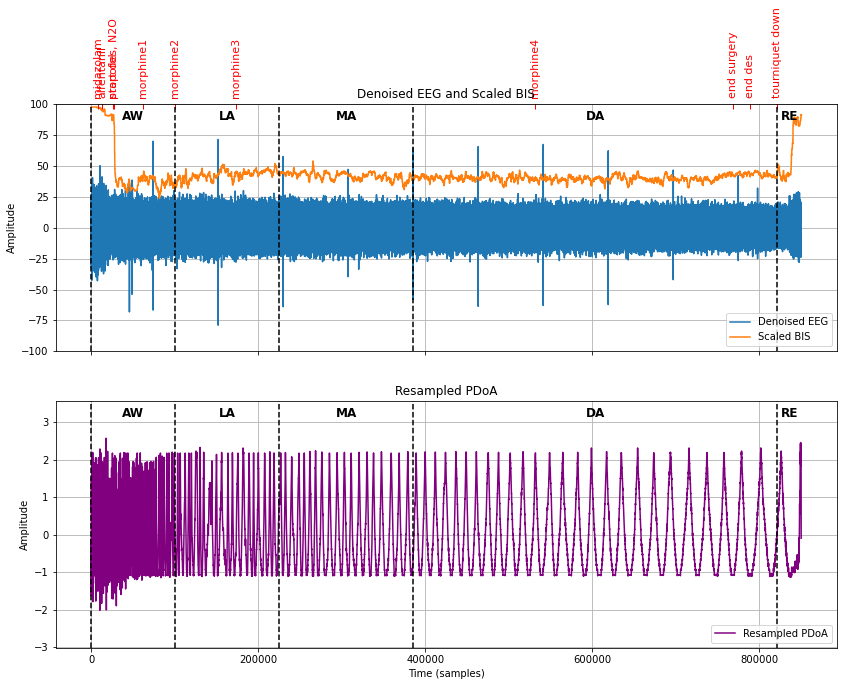

In [8]:
event_times = {
    "midazolam": "17:43:00",
    "alfentanil": "17:43:44",
    "propofol": "17:45:25",
    "start des, N2O": "17:45:30",
    "morphine1": "17:50:00",
    "morphine2": "17:55:00",
    "morphine3": "18:04:30",
    "morphine4": "18:51:10",
    "end surgery": "19:22:00",
    "end des": "19:24:40",
    "tourniquet down": "19:28:57"
}

time_seconds = {}
start_time = "17:42:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128
    
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L05211742, label='Denoised EEG')
axs[0].plot(bis_L05211742, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L05211742, label='Resampled PDoA', color='purple')
axs[1].set_ylim(np.min(pdoa_L05211742.values) - 1, np.max(pdoa_L05211742.values) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L05211742_label = [
    (0, 99840, 'AW'),
    (99840, 225280, 'LA'),
    (225280, 385000, 'MA'),
    (385000, 821370, 'DA'),
    (821370, eeg_length, 'RE')
]

for start, end, label in L05211742_label:
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')

    
plt.show()

In [9]:
eeg_segments = []
labels = []

for start, end, label in L05211742_label:
    eeg_segment = eeg_L05211742['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L05211742_eeg_label.csv', index=False)

In [10]:
# Extract BIS with label
L05211742_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L05211742_label:
    bis_values = bis_L05211742[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L05211742_bis_label = pd.concat([L05211742_bis_label, bis_segment_df], ignore_index=True)

L05211742_bis_label.to_csv('bis_label/L05211742_label.csv', index=False)

### L05200708

In [11]:
#EEG
L05200708 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L05200708.mat')

eeg_L05200708 = L05200708['xh']
eeg_L05200708 = pd.DataFrame(eeg_L05200708)
eeg_L05200708 = eeg_L05200708.stack().reset_index(drop=True).to_frame()
eeg_L05200708.columns = ['eeg']

#BIS
bis_L05200708 = np.repeat(bis['BIS_L05200708'].dropna().values, 128)

#PDOA
pdoa_L05200708 = pd.read_csv('pdoa/05200708.csv', header = None)
pdoa_L05200708.columns = ['X', 'pdoa']

eeg_length = len(eeg_L05200708)
pdoa_resampled = scipy.signal.resample(pdoa_L05200708['pdoa'], eeg_length)
pdoa_L05200708 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

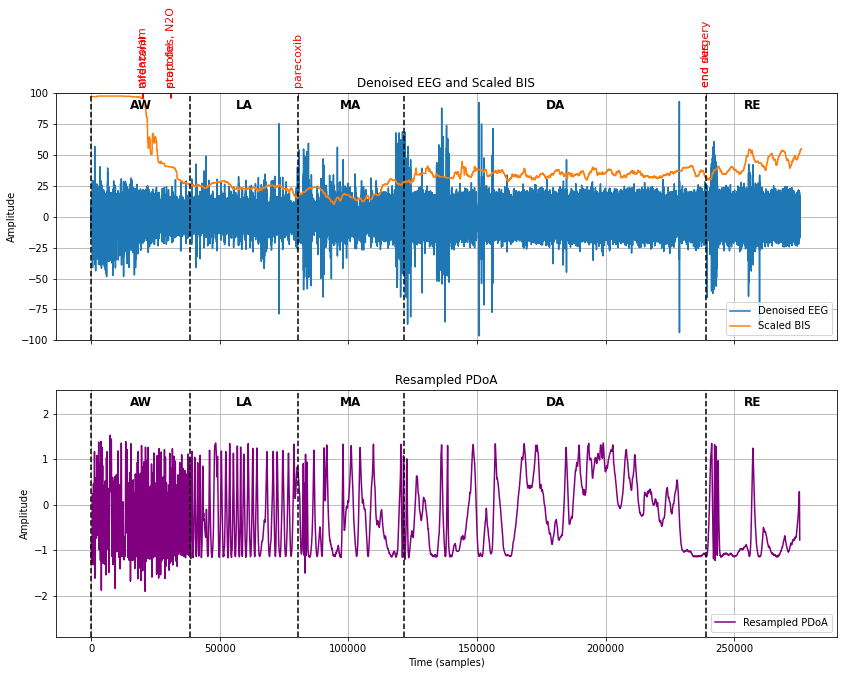

In [12]:
event_times = {
    "midazolam": "07:10:35",
    "alfentanil": "07:10:37",
    "propofol": "07:12:00",
    "start des, N2O": "07:12:02",
    "parecoxib": "07:18:27",
    "end des": "07:39:08",
    "end surgery": "07:39:08"
}

time_seconds = {}
start_time = "07:08:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L05200708, label='Denoised EEG')
axs[0].plot(bis_L05200708, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L05200708, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)
    
L05200708_label = [
    (0, 38400, 'AW'),
    (38400, 80256, 'LA'),
    (80256, 121600, 'MA'),
    (121600, 239104, 'DA'),
    (239104, eeg_length, 'RE')
]

for start, end, label in L05200708_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

x axis (Frequency in Hz): This axis represents the frequency components of the EEG signal, ranging from very low frequencies up to 0.5 Hz. Frequencies beyond this range are not shown, as they likely have little energy or significance in the analysis of anesthesia states.

y-axis (Magnitude): The magnitude on this axis corresponds to the power or energy of the EEG signal at each frequency, as determined by the wavelet transform. Higher magnitudes indicate that the frequency component is more prominent or has more energy in the EEG signal.

Lower frequencies generally show higher magnitudes across all states. As frequency increases, the magnitude decreases for all states. The plot illustrates how the frequency content of the EEG signal changes with different levels of anesthesia. As the patient goes from being awake (AW) to deeper levels of anesthesia (LA, MA, DA), the energy at certain frequency bands decreases. This indicates that brain activity is slowing down and becoming more synchronized. The RE (Recovery) state shows some increase in low-frequency activity as the brain begins to return to a more active state, reflecting the process of emerging from anesthesia.

In [13]:
# Extract EEG with label
eeg_segments = []
labels = []

for start, end, label in L05200708_label:
    eeg_segment = eeg_L05200708['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L05200708_eeg_label.csv', index=False)

In [14]:
# Extract BIS with label
L05200708_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L05200708_label:
    bis_values = bis_L05200708[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L05200708_bis_label = pd.concat([L05200708_bis_label, bis_segment_df], ignore_index=True)

L05200708_bis_label.to_csv('bis_label/L05200708_label.csv', index=False)

### L05250816

In [15]:
#EEG
L05250816 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L05250816.mat')

eeg_L05250816 = L05250816['xh']
eeg_L05250816 = pd.DataFrame(eeg_L05250816)
eeg_L05250816 = eeg_L05250816.stack().reset_index(drop = True).to_frame()
eeg_L05250816.columns = ['eeg']

#BIS
bis_L05250816 = np.repeat(bis['BIS_L05250816'].dropna().values, 128)

#PDOA
pdoa_L05250816 = pd.read_csv('pdoa/05250816.csv', header = None)
pdoa_L05250816.columns = ['X', 'pdoa']

eeg_length = len(eeg_L05250816)
pdoa_resampled = scipy.signal.resample(pdoa_L05250816['pdoa'], eeg_length)
pdoa_L05250816 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

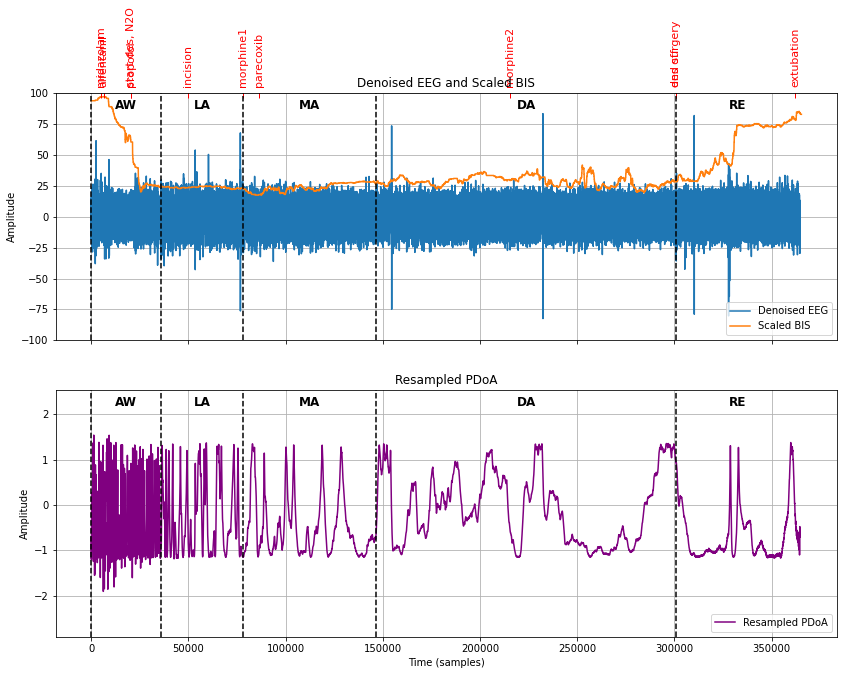

In [16]:
event_times = {
    "midazolam": "08:16:40",
    "alfentanil": "08:16:50",
    "propofol": "08:18:40",
    "start des, N2O": "08:18:40",
    "incision": "08:22:30",
    "morphine1": "08:26:11",
    "parecoxib": "08:27:13",
    "morphine2": "08:44:01",
    "des off": "08:55:11",
    "end surgery": "08:55:11",
    "extubation": "09:03:10"
}

time_seconds = {}
start_time = "08:16:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128
    
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L05250816, label='Denoised EEG')
axs[0].plot(bis_L05250816, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L05250816, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L05250816_label = [
    (0, 35840, 'AW'),
    (35840, 78208, 'LA'),
    (78208, 146560, 'MA'),
    (146560, 300928, 'DA'),
    (300928, eeg_length, 'RE')
]

for start, end, label in L05250816_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [17]:
eeg_segments = []
labels = []

for start, end, label in L05250816_label:
    eeg_segment = eeg_L05250816['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L05250816_eeg_label.csv', index=False)

In [18]:
# Extract BIS with label
L05250816_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L05250816_label:
    bis_values = bis_L05250816[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L05250816_bis_label = pd.concat([L05250816_bis_label, bis_segment_df], ignore_index=True)

L05250816_bis_label.to_csv('bis_label/L05250816_label.csv', index=False)

### L05250921

In [19]:
#EEG
L05250921 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L05250921.mat')

eeg_L05250921 = L05250921['xh']
eeg_L05250921 = pd.DataFrame(eeg_L05250921)
eeg_L05250921 = eeg_L05250921.stack().reset_index(drop = True).to_frame()
eeg_L05250921.columns = ['eeg']

#BIS
bis_L05250921 = np.repeat(bis['BIS L05250921'].dropna().values, 128)
 
#PDOA
pdoa_L05250921 = pd.read_csv('pdoa/05250921.csv', header = None)
pdoa_L05250921.columns = ['X', 'pdoa']

eeg_length = len(eeg_L05250921)
pdoa_resampled = scipy.signal.resample(pdoa_L05250921['pdoa'], eeg_length)
pdoa_L05250921 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

In [20]:
#Normalise
pdoa_L05250921['pdoa'] = (pdoa_L05250921['pdoa'] - pdoa_L05250921['pdoa'].mean()) / pdoa_L05250921['pdoa'].std()

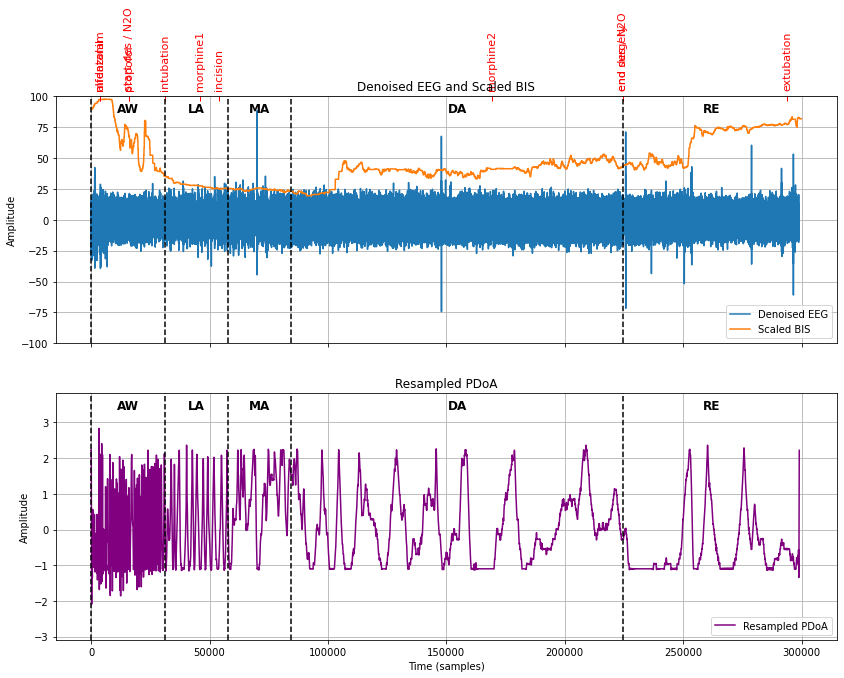

In [21]:
event_times = {
    "midazolam": "09:21:30",
    "alfentanil": "09:21:30",
    "propofol": "09:23:05",
    "start des / N2O": "09:23:05",
    "intubation": "09:25:03",
    "morphine1": "09:26:59",
    "incision": "09:28:00",
    "morphine2": "09:43:03",
    "end surgery": "09:50:14",
    "end des / N2O": "09:50:16",
    "extubation": "09:59:16"
}

time_seconds = {}
start_time = "09:21:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L05250921, label='Denoised EEG')
axs[0].plot(bis_L05250921, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L05250921, label='Resampled PDoA', color='purple')
axs[1].set_ylim(np.min(pdoa_L05250921.values) - 1, np.max(pdoa_L05250921.values) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L05250921_label = [
    (0, 31104, 'AW'),
    (31104, 57600, 'LA'),
    (57600, 84480, 'MA'),
    (84480, 224768, 'DA'),
    (224768, eeg_length, 'RE')
]

for start, end, label in L05250921_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [22]:
eeg_segments = []
labels = []

for start, end, label in L05250921_label:
    eeg_segment = eeg_L05250921['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L05250921_eeg_label.csv', index=False)

In [23]:
# Extract BIS with label
L05250921_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L05250921_label:
    bis_values = bis_L05250921[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L05250921_bis_label = pd.concat([L05250921_bis_label, bis_segment_df], ignore_index=True)

L05250921_bis_label.to_csv('bis_label/L05250921_label.csv', index=False)

### L05271431

In [24]:
#EEG
L05271431 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L05271431.mat')

eeg_L05271431 = L05271431['xh']
eeg_L05271431 = pd.DataFrame(eeg_L05271431)
eeg_L05271431 = eeg_L05271431.stack().reset_index(drop = True).to_frame()
eeg_L05271431.columns = ['eeg']

#BIS
bis_L05271431 = np.repeat(bis['BIS_L05271431'].dropna().values, 128)

#PDOA
pdoa_L05271431 = pd.read_csv('pdoa/05271431.csv', header = None)
pdoa_L05271431.columns = ['X', 'pdoa']

eeg_length = len(eeg_L05271431)
pdoa_resampled = scipy.signal.resample(pdoa_L05271431['pdoa'], eeg_length)
pdoa_L05271431 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

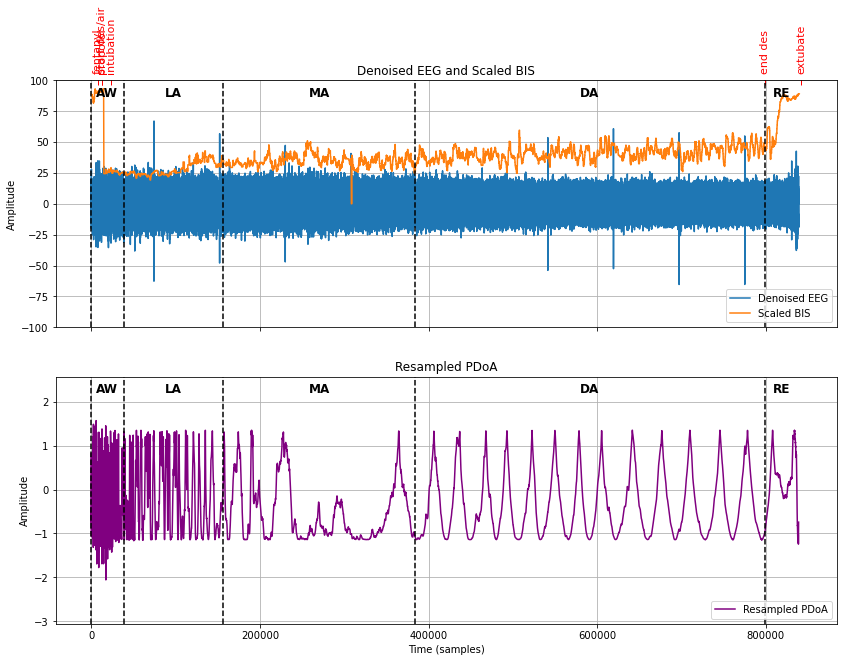

In [25]:
event_times = {
    "fentanyl": "14:32:03",
    "propofol": "14:32:42",
    "start des/air": "14:32:44",
    "intubation": "14:34:00",
    "end des": "16:15:00",
    "extubate": "16:20:38"
}

time_seconds = {}
start_time = "14:31:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L05271431, label='Denoised EEG')
axs[0].plot(bis_L05271431, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L05271431, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L05271431_label = [
    (0, 38400, 'AW'),
    (38400, 156160, 'LA'),
    (156160, 384000, 'MA'),
    (384000, 798720, 'DA'),
    (798720, eeg_length, 'RE')
]

for start, end, label in L05271431_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [26]:
eeg_segments = []
labels = []

for start, end, label in L05271431_label:
    eeg_segment = eeg_L05271431['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L05271431_eeg_label.csv', index=False)

In [27]:
# Extract BIS with label
L05271431_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L05271431_label:
    bis_values = bis_L05271431[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L05271431_bis_label = pd.concat([L05271431_bis_label, bis_segment_df], ignore_index=True)

L05271431_bis_label.to_csv('bis_label/L05271431_label.csv', index=False)

### L05281010

In [28]:
#EEG
L05281010 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L05281010.mat')

eeg_L05281010 = L05281010['xh']
eeg_L05281010 = pd.DataFrame(eeg_L05281010)
eeg_L05281010 = eeg_L05281010.stack().reset_index(drop = True).to_frame()
eeg_L05281010.columns = ['eeg']

#BIS
bis_L05281010 = np.repeat(bis['BIS_05281010'].dropna().values, 128)

#PDOA
pdoa_L05281010 = pd.read_csv('pdoa/05281010.csv', header = None)
pdoa_L05281010.columns = ['X', 'pdoa']

eeg_length = len(eeg_L05281010)
pdoa_resampled = scipy.signal.resample(pdoa_L05281010['pdoa'], eeg_length)
pdoa_L05281010 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

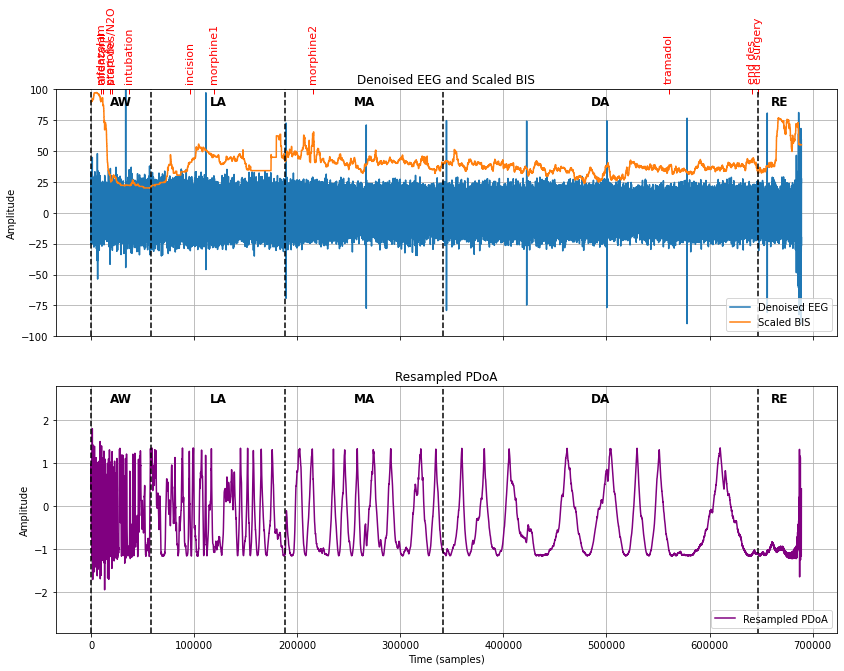

In [29]:
event_times = {
    "midazolam": "10:11:12",
    "alfentanil": "10:11:26",
    "propofol": "10:12:20",
    "start des/N2O": "10:12:38",
    "intubation": "10:14:45",
    "incision": "10:22:28",
    "morphine1": "10:25:30",
    "morphine2": "10:38:02",
    "tramadol": "11:23:00",
    "end des": "11:33:33",
    "end surgery": "11:34:15"
}

time_seconds = {}
start_time = "10:10:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L05281010, label='Denoised EEG')
axs[0].plot(bis_L05281010, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L05281010, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L05281010_label = [
    (0, 57600, 'AW'),
    (57600, 188160, 'LA'),
    (188160, 341760, 'MA'),
    (341760, 647040, 'DA'),
    (647040, eeg_length, 'RE')
]

for start, end, label in L05281010_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [30]:
eeg_segments = []
labels = []

for start, end, label in L05281010_label:
    eeg_segment = eeg_L05281010['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L05281010_eeg_label.csv', index=False)

In [31]:
# Extract BIS with label
L05281010_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L05281010_label:
    bis_values = bis_L05281010[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L05281010_bis_label = pd.concat([L05281010_bis_label, bis_segment_df], ignore_index=True)

L05281010_bis_label.to_csv('bis_label/L05281010_label.csv', index=False)

### L06101015

In [32]:
#EEG
L06101015 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L06101015.mat')

eeg_L06101015 = L06101015['xh']
eeg_L06101015 = pd.DataFrame(eeg_L06101015)
eeg_L06101015 = eeg_L06101015.stack().reset_index(drop = True).to_frame()
eeg_L06101015.columns = ['eeg']

#BIS
bis_L06101015 = np.repeat(bis['BIS_L06101015'].dropna().values, 128)

#PDOA
pdoa_L06101015 = pd.read_csv('pdoa/06101015.csv', header = None)
pdoa_L06101015.columns = ['X', 'pdoa']

eeg_length = len(eeg_L06101015)
pdoa_resampled = scipy.signal.resample(pdoa_L06101015['pdoa'], eeg_length)
pdoa_L06101015 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

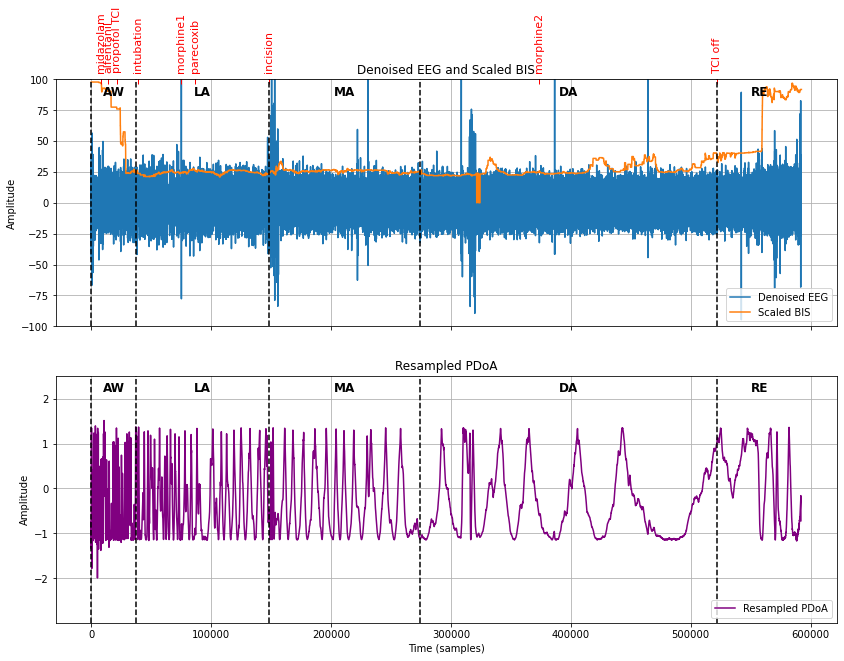

In [33]:
event_times = {
    "midazolam": "10:16:05",
    "alfentanil": "10:16:51",
    "propofol TCI": "10:17:47",
    "intubation": "10:20:08",
    "morphine1": "10:24:45",
    "parecoxib": "10:26:13",
    "incision": "10:34:16",
    "morphine2": "11:03:35",
    "TCI off": "11:23:00"
}

time_seconds = {}
start_time = "10:15:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L06101015, label='Denoised EEG')
axs[0].plot(bis_L06101015, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L06101015, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L06101015_label = [
    (0, 37120, 'AW'),
    (37120, 147968, 'LA'),
    (147968, 273920, 'MA'),
    (273920, 522240, 'DA'),
    (522240, eeg_length, 'RE')
]

for start, end, label in L06101015_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [34]:
eeg_segments = []
labels = []

for start, end, label in L06101015_label:
    eeg_segment = eeg_L06101015['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L06101015_eeg_label.csv', index=False)

In [35]:
# Extract BIS with label
L06101015_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L06101015_label:
    bis_values = bis_L06101015[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L06101015_bis_label = pd.concat([L06101015_bis_label, bis_segment_df], ignore_index=True)

L06101015_bis_label.to_csv('bis_label/L06101015_label.csv', index=False)

### L06181302

In [36]:
#EEG
L06181302 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L06181302.mat')

eeg_L06181302 = L06181302['xh']
eeg_L06181302 = pd.DataFrame(eeg_L06181302)
eeg_L06181302 = eeg_L06181302.stack().reset_index(drop = True).to_frame()
eeg_L06181302.columns = ['eeg']

#BIS
bis_L06181302 = np.repeat(bis['BIS_L06181302'].dropna().values, 128)

#PDOA
pdoa_L06181302 = pd.read_csv('pdoa/06181302.csv', header = None)
pdoa_L06181302.columns = ['X', 'pdoa']

eeg_length = len(eeg_L06181302)
pdoa_resampled = scipy.signal.resample(pdoa_L06181302['pdoa'], eeg_length)
pdoa_L06181302 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

In [37]:
#Normalise
pdoa_L06181302['pdoa'] = (pdoa_L06181302['pdoa'] - pdoa_L06181302['pdoa'].mean()) / pdoa_L06181302['pdoa'].std()

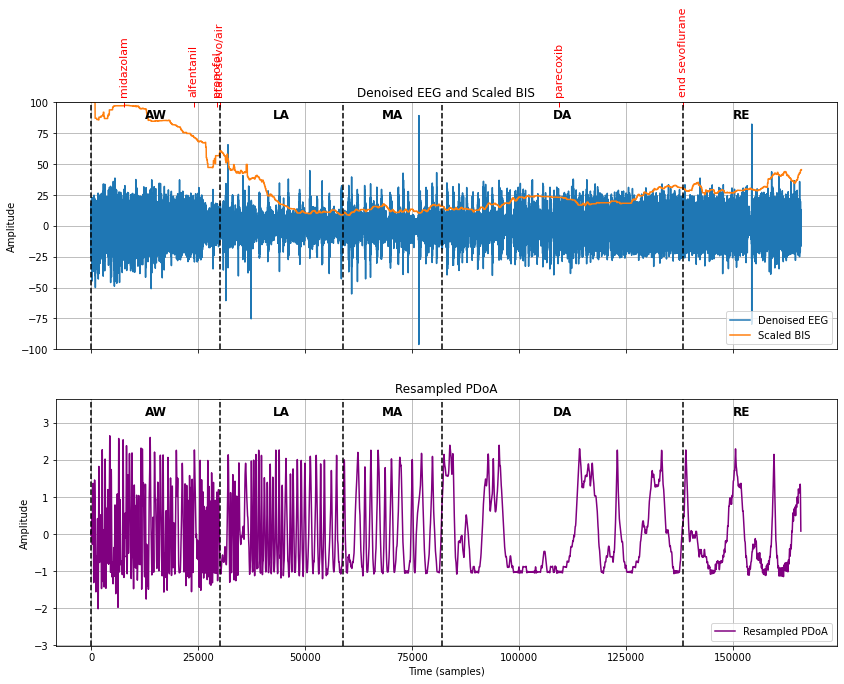

In [38]:
event_times = {
    "midazolam": "13:03:00",
    "alfentanil": "13:05:07",
    "propofol": "13:05:50",
    "start sevo/air": "13:05:55",
    "parecoxib": "13:16:15",
    "end sevoflurane": "13:20:00"
}

time_seconds = {}
start_time = "13:02:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L06181302, label='Denoised EEG')
axs[0].plot(bis_L06181302, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L06181302, label='Resampled PDoA', color='purple')
axs[1].set_ylim(np.min(pdoa_L06181302.values) - 1, np.max(pdoa_L06181302.values) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L06181302_label = [
    (0, 30080, 'AW'),
    (30080, 58880, 'LA'),
    (58880, 81920, 'MA'),
    (81920, 138240, 'DA'),
    (138240, eeg_length, 'RE')
]

for start, end, label in L06181302_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [39]:
eeg_segments = []
labels = []

for start, end, label in L06181302_label:
    eeg_segment = eeg_L06181302['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L06181302_eeg_label.csv', index=False)

In [40]:
# Extract BIS with label
L06181302_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L06181302_label:
    bis_values = bis_L06181302[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L06181302_bis_label = pd.concat([L06181302_bis_label, bis_segment_df], ignore_index=True)

L06181302_bis_label.to_csv('bis_label/L06181302_label.csv', index=False)

### L06181332

In [41]:
#EEG
L06181332 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L06181332.mat')

eeg_L06181332 = L06181332['xh']
eeg_L06181332 = pd.DataFrame(eeg_L06181332)
eeg_L06181332 = eeg_L06181332.stack().reset_index(drop = True).to_frame()
eeg_L06181332.columns = ['eeg']

#BIS
bis_L06181332 = np.repeat(bis['BIS_L06181332'].dropna().values, 128)

#PDOA
pdoa_L06181332 = pd.read_csv('pdoa/06181332.csv', header = None)
pdoa_L06181332.columns = ['X', 'pdoa']

eeg_length = len(eeg_L06181332)
pdoa_resampled = scipy.signal.resample(pdoa_L06181332['pdoa'], eeg_length)
pdoa_L06181332 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

In [42]:
#Normalise
pdoa_L06181332['pdoa'] = (pdoa_L06181332['pdoa'] - pdoa_L06181332['pdoa'].mean()) / pdoa_L06181332['pdoa'].std()

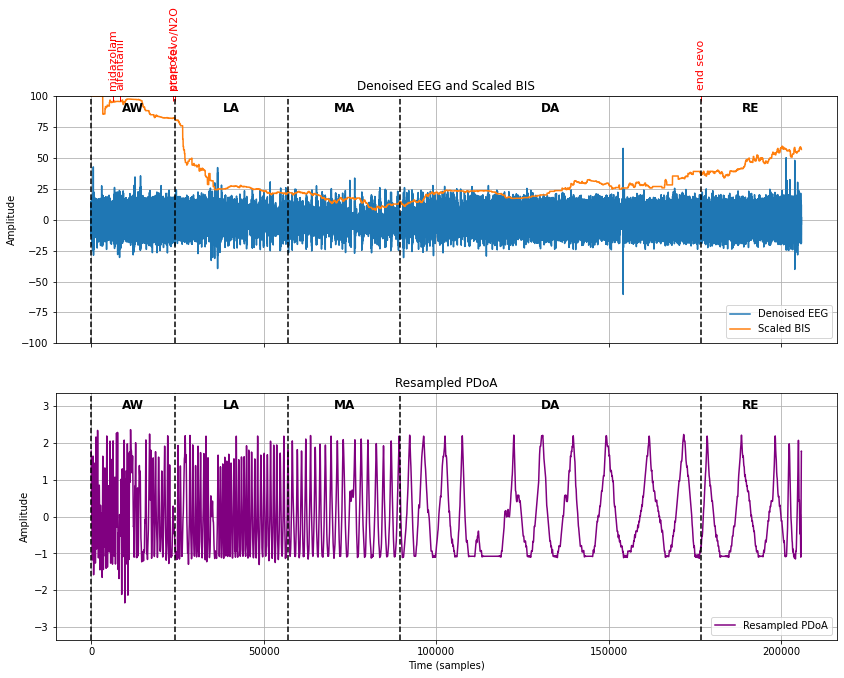

In [43]:
event_times = {
    "midazolam": "13:32:50",
    "alfentanil": "13:33:05",
    "propofol": "13:35:05",
    "start sevo/N2O": "13:35:10",
    "end sevo": "13:55:00"
}

time_seconds = {}
start_time = "13:32:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L06181332, label='Denoised EEG')
axs[0].plot(bis_L06181332, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L06181332, label='Resampled PDoA', color='purple')
axs[1].set_ylim(np.min(pdoa_L06181332.values) - 1, np.max(pdoa_L06181332.values) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L06181332_label = [
    (0, 24320, 'AW'),
    (24320, 56960, 'LA'),
    (56960, 89600, 'MA'),
    (89600, 176640, 'DA'),
    (176640, eeg_length, 'RE')
]

for start, end, label in L06181332_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [44]:
eeg_segments = []
labels = []

for start, end, label in L06181332_label:
    eeg_segment = eeg_L06181332['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L06181332_eeg_label.csv', index=False)

In [45]:
# Extract BIS with label
L06181332_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L06181332_label:
    bis_values = bis_L06181332[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L06181332_bis_label = pd.concat([L06181332_bis_label, bis_segment_df], ignore_index=True)

L06181332_bis_label.to_csv('bis_label/L06181332_label.csv', index=False)

### L06221009

In [46]:
#EEG
L06221009 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L06221009.mat')

eeg_L06221009 = L06221009['xh']
eeg_L06221009 = pd.DataFrame(eeg_L06221009)
eeg_L06221009 = eeg_L06221009.stack().reset_index(drop = True).to_frame()
eeg_L06221009.columns = ['eeg']

#BIS
bis_L06221009 = np.repeat(bis['BISL06221009'].dropna().values, 128)

#PDOA
pdoa_L06221009 = pd.read_csv('pdoa/06221009.csv', header = None)
pdoa_L06221009.columns = ['X', 'pdoa']

eeg_length = len(eeg_L06221009)
pdoa_resampled = scipy.signal.resample(pdoa_L06221009['pdoa'], eeg_length)
pdoa_L06221009 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

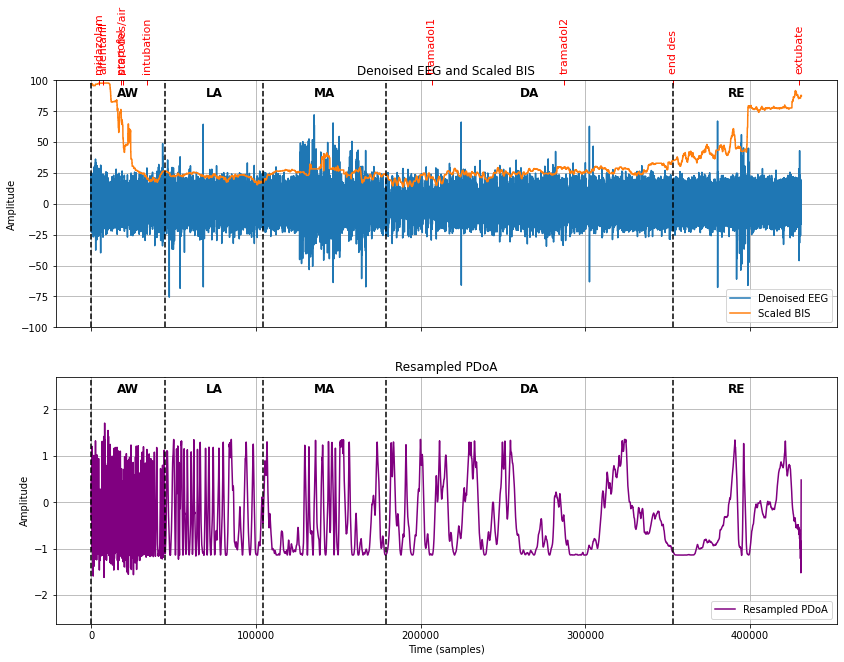

In [47]:
event_times = {
    "midazolam": "10:09:38",
    "alfentanil": "10:09:58",
    "propofol": "10:11:23",
    "start des/air": "10:11:30",
    "intubation": "10:13:24",
    "tramadol1": "10:35:55",
    "tramadol2": "10:46:25",
    "end des": "10:55:00",
    "extubate": "11:05:00"
}

time_seconds = {}
start_time = "10:09:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L06221009, label='Denoised EEG')
axs[0].plot(bis_L06221009, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L06221009, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L06221009_label = [
    (0, 44800, 'AW'),
    (44800, 104500, 'LA'),
    (104500, 179200, 'MA'),
    (179200, 353280, 'DA'),
    (353280, eeg_length, 'RE')
]

for start, end, label in L06221009_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [48]:
eeg_segments = []
labels = []

for start, end, label in L06221009_label:
    eeg_segment = eeg_L06221009['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L06221009_eeg_label.csv', index=False)

In [49]:
# Extract BIS with label
L06221009_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L06221009_label:
    bis_values = bis_L06221009[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L06221009_bis_label = pd.concat([L06221009_bis_label, bis_segment_df], ignore_index=True)

L06221009_bis_label.to_csv('bis_label/L06221009_label.csv', index=False)

### L06221141

In [50]:
#EEG
L06221141 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L06221141.mat')

eeg_L06221141 = L06221141['xh']
eeg_L06221141 = pd.DataFrame(eeg_L06221141)
eeg_L06221141 = eeg_L06221141.stack().reset_index(drop = True).to_frame()
eeg_L06221141.columns = ['eeg']

#BIS
bis_L06221141 = np.repeat(bis['BIS_L06221141'].dropna().values, 128)

#PDOA
pdoa_L06221141 = pd.read_csv('pdoa/06221141.csv', header = None)
pdoa_L06221141.columns = ['X', 'pdoa']

eeg_length = len(eeg_L06221141)
pdoa_resampled = scipy.signal.resample(pdoa_L06221141['pdoa'], eeg_length)
pdoa_L06221141 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

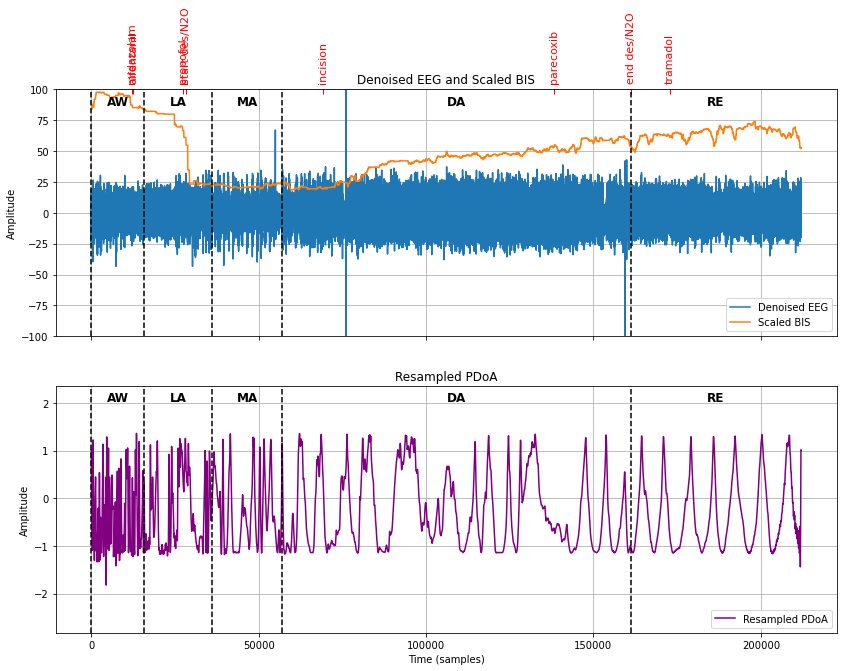

In [51]:
event_times = {
    "midazolam": "11:42:35",
    "alfentanil": "11:42:38",
    "propofol": "11:44:35",
    "start des/N2O": "11:44:40",
    "incision": "11:50:00",
    "parecoxib": "11:59:00",
    "end des/N2O": "12:02:00",
    "tramadol": "12:03:30"
}

time_seconds = {}
start_time = "11:41:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L06221141, label='Denoised EEG')
axs[0].plot(bis_L06221141, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L06221141, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L06221141_label = [
    (0, 15872, 'AW'),
    (15872, 36096, 'LA'),
    (36096, 56960, 'MA'),
    (56960, 161280, 'DA'),
    (161280, eeg_length, 'RE')
]

for start, end, label in L06221141_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [52]:
eeg_segments = []
labels = []

for start, end, label in L06221141_label:
    eeg_segment = eeg_L06221141['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L06221141_eeg_label.csv', index=False)

In [53]:
# Extract BIS with label
L06221141_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L06221141_label:
    bis_values = bis_L06221141[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L06221141_bis_label = pd.concat([L06221141_bis_label, bis_segment_df], ignore_index=True)

L06221141_bis_label.to_csv('bis_label/L06221141_label.csv', index=False)

### L06221219

In [54]:
#EEG
L06221219 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L06221219.mat')

eeg_L06221219 = L06221219['xh']
eeg_L06221219 = pd.DataFrame(eeg_L06221219)
eeg_L06221219 = eeg_L06221219.stack().reset_index(drop = True).to_frame()
eeg_L06221219.columns = ['eeg']

#BIS
bis_L06221219 = np.repeat(bis['BIS_L06221219'].dropna().values, 128)

#PDOA
pdoa_L06221219 = pd.read_csv('pdoa/06221219.csv', header = None)
pdoa_L06221219.columns = ['X', 'pdoa']

eeg_length = len(eeg_L06221219)
pdoa_resampled = scipy.signal.resample(pdoa_L06221219['pdoa'], eeg_length)
pdoa_L06221219 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

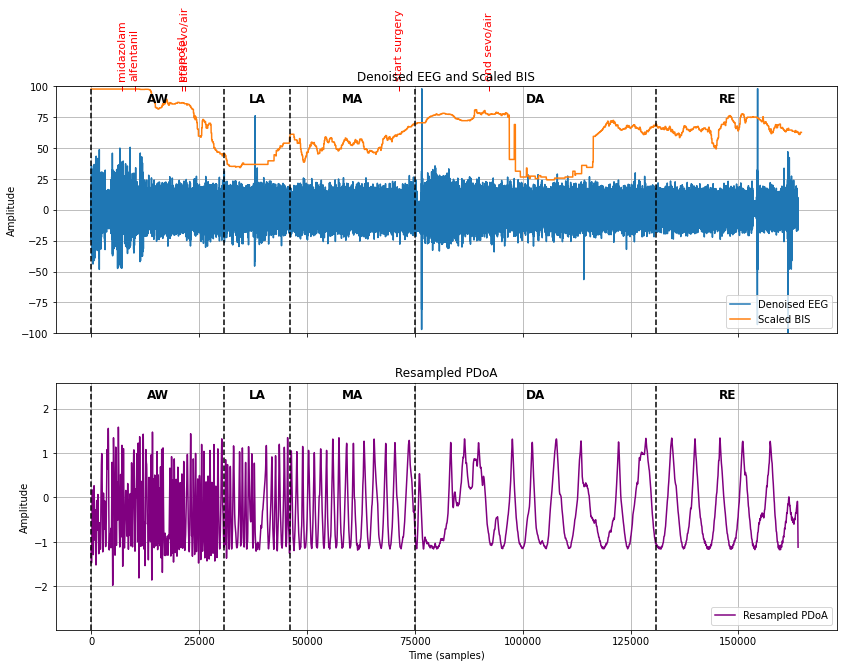

In [55]:
event_times = {
    "midazolam": "12:19:55",
    "alfentanil": "12:20:19",
    "propofol": "12:21:45",
    "start sevo/air": "12:21:50",
    "start surgery": "12:28:18",
    "end sevo/air": "12:31:00"
}

time_seconds = {}
start_time = "12:19:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L06221219, label='Denoised EEG')
axs[0].plot(bis_L06221219, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L06221219, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L06221219_label = [
    (0, 30720, 'AW'),
    (30720, 46080, 'LA'),
    (46080, 75000, 'MA'), #time start surgery
    (75000, 131000, 'DA'),
    (131000, eeg_length, 'RE')
]

for start, end, label in L06221219_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [56]:
eeg_segments = []
labels = []

for start, end, label in L06221219_label:
    eeg_segment = eeg_L06221219['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L06221219_eeg_label.csv', index=False)

In [57]:
# Extract BIS with label
L06221219_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L06221219_label:
    bis_values = bis_L06221219[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L06221219_bis_label = pd.concat([L06221219_bis_label, bis_segment_df], ignore_index=True)

L06221219_bis_label.to_csv('bis_label/L06221219_label.csv', index=False)

### L08181442

In [58]:
#EEG
L08181442 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L08181442.mat')

eeg_L08181442 = L08181442['xh']
eeg_L08181442 = pd.DataFrame(eeg_L08181442)
eeg_L08181442 = eeg_L08181442.stack().reset_index(drop = True).to_frame()
eeg_L08181442.columns = ['eeg']

#BIS
bis_L08181442 = np.repeat(bis['BIS_L08181442'].dropna().values, 128)

#PDOA
pdoa_L08181442 = pd.read_csv('pdoa/08181442.csv', header = None)
pdoa_L08181442.columns = ['X', 'pdoa']

eeg_length = len(eeg_L08181442)
pdoa_resampled = scipy.signal.resample(pdoa_L08181442['pdoa'], eeg_length)
pdoa_L08181442 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

In [59]:
#Normalise
pdoa_L08181442['pdoa'] = (pdoa_L08181442['pdoa'] - pdoa_L08181442['pdoa'].mean()) / pdoa_L08181442['pdoa'].std()

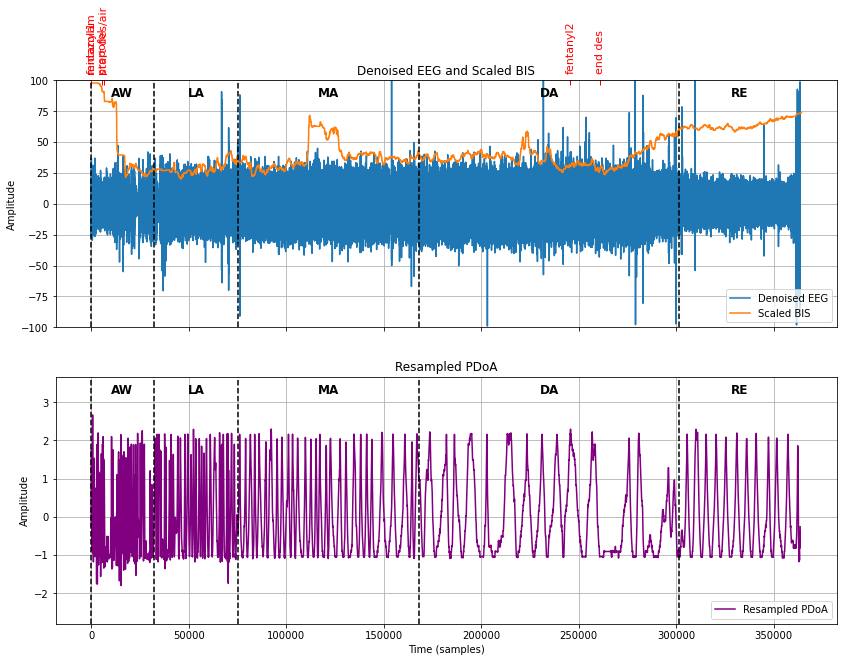

In [60]:
event_times = {
    "midazolam": "14:43:00",
    "fentanyl1": "14:43:00",
    "propofol": "14:43:45",
    "start des/air": "14:43:50",
    "fentanyl2": "15:15:00",
    "end des": "15:17:00"
}

time_seconds = {}
start_time = "14:43:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L08181442, label='Denoised EEG')
axs[0].plot(bis_L08181442, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L08181442, label='Resampled PDoA', color='purple')
axs[1].set_ylim(np.min(pdoa_L08181442.values) - 1, np.max(pdoa_L08181442.values) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L08181442_label = [
    (0, 32000, 'AW'),
    (32000, 75520, 'LA'),
    (75520, 168000, 'MA'),
    (168000, 301500, 'DA'),
    (301500, eeg_length, 'RE')
]

for start, end, label in L08181442_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [61]:
eeg_segments = []
labels = []

for start, end, label in L08181442_label:
    eeg_segment = eeg_L08181442['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L08181442_eeg_label.csv', index=False)

In [62]:
# Extract BIS with label
L08181442_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L08181442_label:
    bis_values = bis_L08181442[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L08181442_bis_label = pd.concat([L08181442_bis_label, bis_segment_df], ignore_index=True)

L08181442_bis_label.to_csv('bis_label/L08181442_label.csv', index=False)

### L08190811

In [63]:
#EEG
L08190811 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L08190811.mat')

eeg_L08190811 = L08190811['xh']
eeg_L08190811 = pd.DataFrame(eeg_L08190811)
eeg_L08190811 = eeg_L08190811.stack().reset_index(drop = True).to_frame()
eeg_L08190811.columns = ['eeg']

#BIS
bis_L08190811 = np.repeat(bis['BIS_L08190811'].dropna().values, 128)

#PDOA
pdoa_L08190811 = pd.read_csv('pdoa/08190811.csv', header = None)
pdoa_L08190811.columns = ['X', 'pdoa']

eeg_length = len(eeg_L08190811)
pdoa_resampled = scipy.signal.resample(pdoa_L08190811['pdoa'], eeg_length)
pdoa_L08190811 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

In [64]:
#Normalise
pdoa_L08190811['pdoa'] = (pdoa_L08190811['pdoa'] - pdoa_L08190811['pdoa'].mean()) / pdoa_L08190811['pdoa'].std()

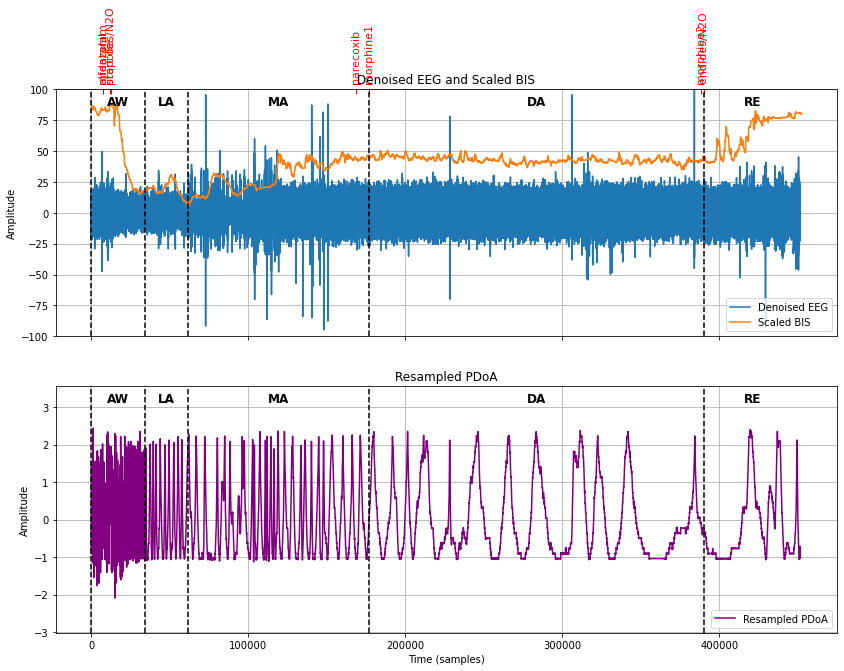

In [65]:
event_times = {
    "midazolam": "08:12:00",
    "alfentanil": "08:12:00",
    "propofol": "08:12:35",
    "start des/N2O": "08:12:40",
    "parecoxib": "08:33:00",
    "morphine1": "08:34:00",
    "morphine2": "09:01:35",
    "end des/N2O": "09:01:50"
}

time_seconds = {}
start_time = "08:11:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L08190811, label='Denoised EEG')
axs[0].plot(bis_L08190811, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L08190811, label='Resampled PDoA', color='purple')
axs[1].set_ylim(np.min(pdoa_L05211742.values) - 1, np.max(pdoa_L05211742.values) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L08190811_label = [
    (0, 34560, 'AW'),
    (34560, 61440, 'LA'),
    (61440, 176640, 'MA'),
    (176640, 390400, 'DA'),
    (390400, eeg_length, 'RE')
]

for start, end, label in L08190811_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [66]:
eeg_segments = []
labels = []

for start, end, label in L08190811_label:
    eeg_segment = eeg_L08190811['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L08190811_eeg_label.csv', index=False)

In [67]:
# Extract BIS with label
L08190811_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L08190811_label:
    bis_values = bis_L08190811[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L08190811_bis_label = pd.concat([L08190811_bis_label, bis_segment_df], ignore_index=True)

L08190811_bis_label.to_csv('bis_label/L08190811_label.csv', index=False)

### L08190921

In [68]:
#EEG
L08190921 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L08190921.mat')

eeg_L08190921 = L08190921['xh']
eeg_L08190921 = pd.DataFrame(eeg_L08190921)
eeg_L08190921 = eeg_L08190921.stack().reset_index(drop = True).to_frame()
eeg_L08190921.columns = ['eeg']

#BIS
bis_L08190921 = np.repeat(bis['BIS_L08190921'].dropna().values, 128)

#PDOA
pdoa_L08190921 = pd.read_csv('pdoa/08190921.csv', header = None)
pdoa_L08190921.columns = ['X', 'pdoa']

eeg_length = len(eeg_L08190921)
pdoa_resampled = scipy.signal.resample(pdoa_L08190921['pdoa'], eeg_length)
pdoa_L08190921 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

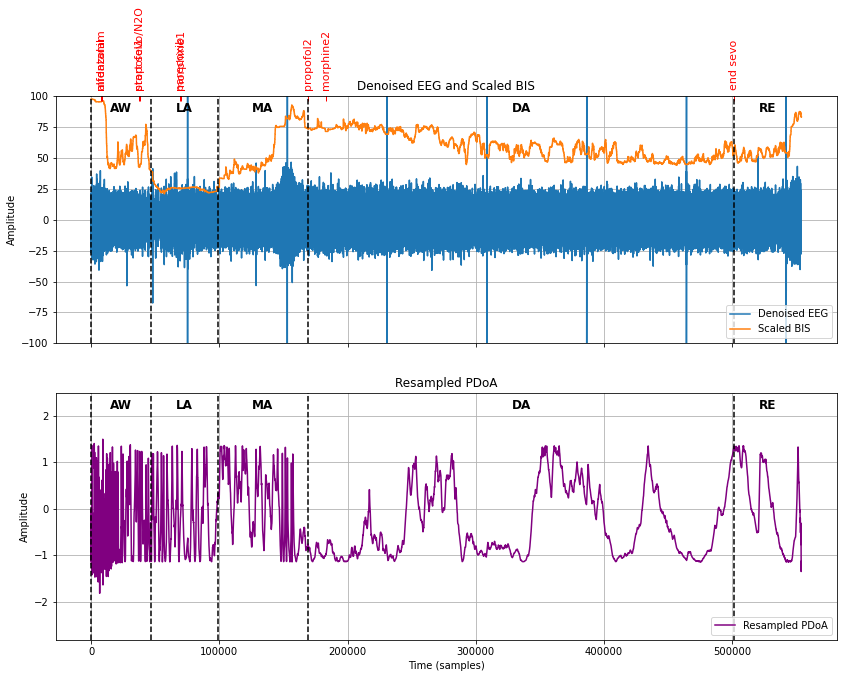

In [69]:
event_times = {
    "midazolam": "09:22:00",
    "alfentanil": "09:22:03",
    "propofol1": "09:25:53",
    "start sevo/N2O": "09:25:55",
    "parecoxib": "09:30:00",
    "morphine1": "09:30:05",
    "propofol2": "09:43:00",
    "morphine2": "09:44:50",
    "end sevo": "10:26:20"
}

time_seconds = {}
start_time = "09:21:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L08190921, label='Denoised EEG')
axs[0].plot(bis_L08190921, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L08190921, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L08190921_label = [
    (0, 47000, 'AW'),
    (47000, 98560, 'LA'),
    (98560, 168960, 'MA'),
    (168960, 501760, 'DA'),
    (501760, eeg_length, 'RE')
]

for start, end, label in L08190921_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [70]:
eeg_segments = []
labels = []

for start, end, label in L08190921_label:
    eeg_segment = eeg_L08190921['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L08190921_eeg_label.csv', index=False)

In [71]:
# Extract BIS with label
L08190921_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L08190921_label:
    bis_values = bis_L08190921[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L08190921_bis_label = pd.concat([L08190921_bis_label, bis_segment_df], ignore_index=True)

L08190921_bis_label.to_csv('bis_label/L08190921_label.csv', index=False)

## Visualisation

In [72]:
patient_list = [
    "L05200708",
    "L05211742",
    "L05250816",
    "L05250921",
    "L05271431",
    "L05281010",
    "L06101015",
    "L06181302",
    "L06181332",
    "L06221009",
    "L06221141",
    "L06221219",
    "L08181442",
    "L08190811",
    "L08190921"]

In [47]:
entropy_df = pd.DataFrame(columns=['Patient', 'State', 'Time', 'Entropy'])

# Set the window size for 30 seconds (EEG is sampled at 128Hz)
sampling_rate = 128
window_size = 30 * sampling_rate

# Loop through each patient and calculate entropy in 30-second windows
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']['eeg'].values  # Load EEG data for patient
    labels = globals()[f'{patient}_label']  # Load the label data for each patient
    
    for start, end, label in labels:
        # Loop through the EEG data in 30-second windows for the current state
        for i in range(start, end, window_size):
            eeg_segment = eeg_data[i:i + window_size]
            
            if len(eeg_segment) == window_size: 
                entropy = shannon_entropy(eeg_segment)
                time_point = i / sampling_rate  # Time in seconds
                
                # Append to DataFrame
                entropy_df = pd.concat([entropy_df, pd.DataFrame({
                    'Patient': [patient],
                    'State': [label],
                    'Time': [time_point],
                    'Entropy': [entropy]
                })], ignore_index=True)

print(entropy_df)

        Patient State    Time   Entropy
0     L05200708    AW     0.0  2.011132
1     L05200708    AW    30.0  2.034906
2     L05200708    AW    60.0  2.083088
3     L05200708    AW    90.0  2.210748
4     L05200708    AW   120.0  2.072042
...         ...   ...     ...       ...
1692  L08190921    RE  4160.0  2.574815
1693  L08190921    RE  4190.0  2.428505
1694  L08190921    RE  4220.0  1.082551
1695  L08190921    RE  4250.0  2.569844
1696  L08190921    RE  4280.0  2.548618

[1697 rows x 4 columns]


In [48]:
bis_data_list = []

# Loop through each patient and extract BIS values for each state
for patient in patient_list:
    bis_data = globals()[f'bis_{patient}']  # Load BIS data for patient
    labels = globals()[f'{patient}_label']  # Load state labels for the patient
    
    # Loop over the label ranges (start, end, label) for each state
    for start, end, label in labels:
        # Extract the BIS data for the state
        bis_state = bis_data[start:end]
        
        # Collect BIS data in the list (for batch processing)
        for i, bis_value in enumerate(bis_state):
            time_point = (start + i) 
            bis_data_list.append({
                'Patient': patient,
                'State': label,
                'Time': time_point,
                'BIS': bis_value
            })

bis_df = pd.DataFrame(bis_data_list)
print(bis_df)

           Patient State    Time   BIS
0        L05200708    AW       0  97.3
1        L05200708    AW       1  97.3
2        L05200708    AW       2  97.3
3        L05200708    AW       3  97.3
4        L05200708    AW       4  97.3
...            ...   ...     ...   ...
6456300  L08190921    RE  553978  83.0
6456301  L08190921    RE  553979  83.0
6456302  L08190921    RE  553980  83.0
6456303  L08190921    RE  553981  83.0
6456304  L08190921    RE  553982  83.0

[6456305 rows x 4 columns]


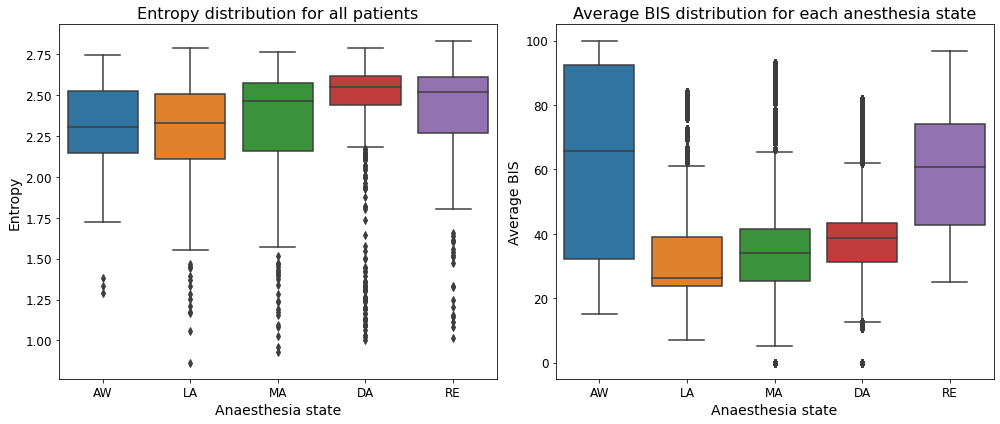

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the Entropy vs Anesthesia State for All Patients
sns.boxplot(x='State', y='Entropy', data=entropy_df, ax=axes[0])
axes[0].set_title('Entropy distribution for all patients', fontsize=16)
axes[0].set_xlabel('Anaesthesia state', fontsize=14)
axes[0].set_ylabel('Entropy', fontsize=14)

axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Plot the Average BIS Distribution for Each Anesthesia State
sns.boxplot(x='State', y='BIS', data=bis_df, ax=axes[1])
axes[1].set_title('BIS distribution for each anesthesia state', fontsize=16)
axes[1].set_xlabel('Anaesthesia state', fontsize=14)
axes[1].set_ylabel('Average BIS', fontsize=14)

axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

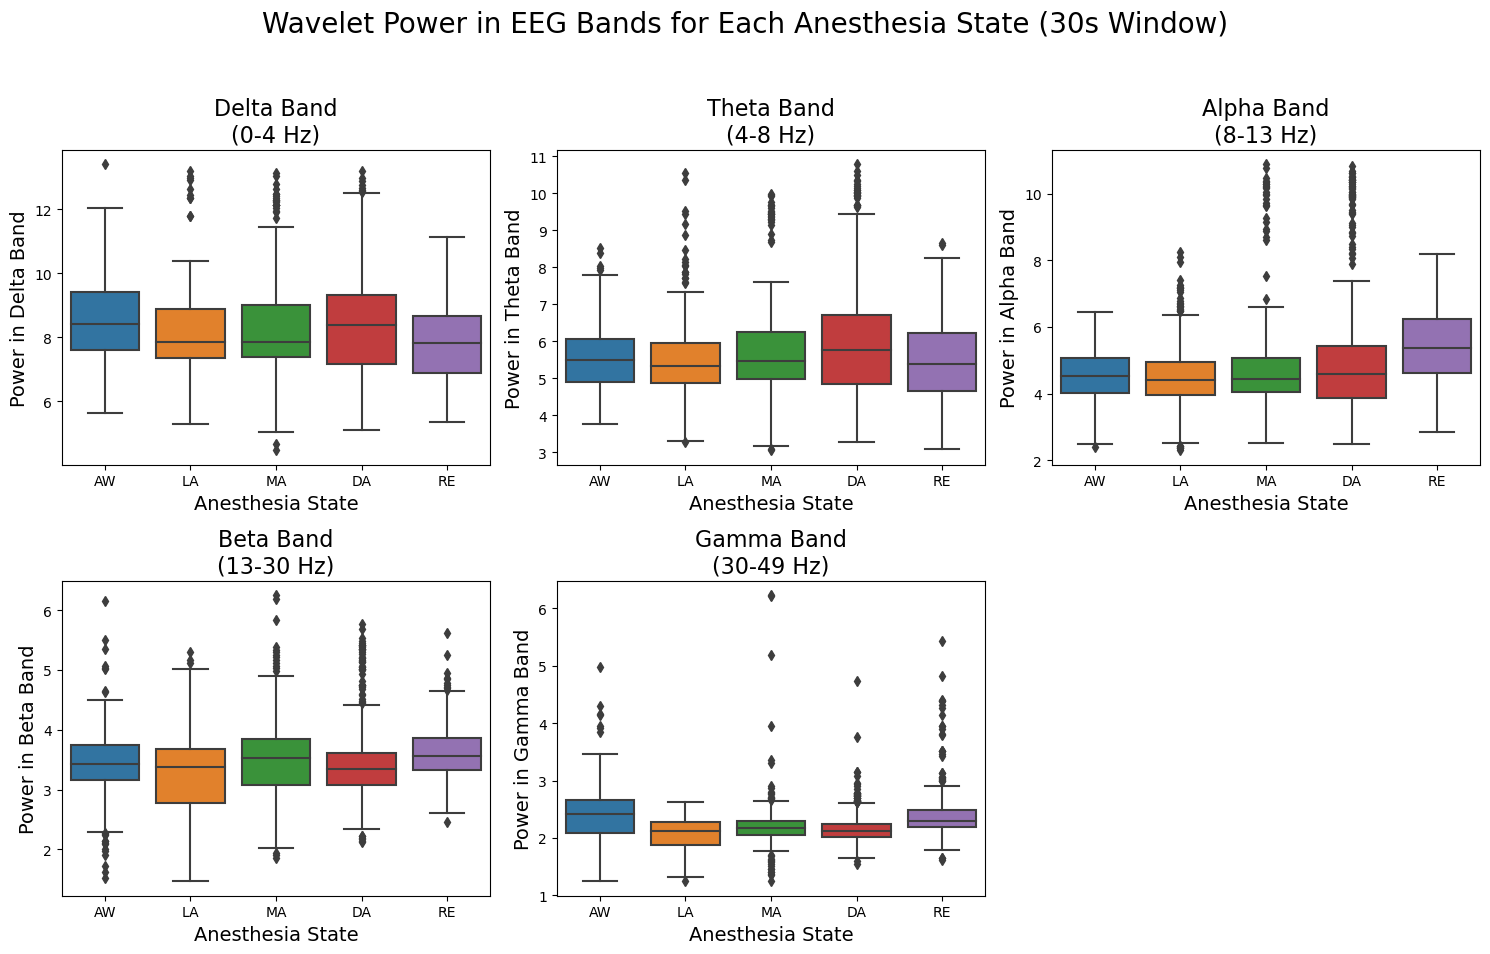

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define EEG bands in Hz
eeg_bands = {
    "Delta": (0, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 49)
}

# Create an empty DataFrame to store results
wavelet_power_df = pd.DataFrame(columns=['Patient', 'State', 'Band', 'Power'])

# Loop through patients and states to calculate and store wavelet power for each band
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']  # Load EEG data
    labels = globals()[f'{patient}_label']  # Load state labels
    
    for start, end, label in labels:
        # Segment EEG data into 30-second windows
        for i in range(start, end, window_size):
            if i + window_size > end:
                break  # Skip incomplete windows if any
            state_eeg = eeg_data['eeg'][i:i+window_size].values
            
            # Calculate wavelet transform and average coefficients
            frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
            
            # Store power for each band
            for band_name, band_range in eeg_bands.items():
                band_power = calculate_band_power(frequencies, avg_coefficients, band_range)
                
                # Store in DataFrame
                new_row = pd.DataFrame({
                    'Patient': [patient],
                    'State': [label],
                    'Band': [band_name],
                    'Power': [band_power]
                })
                wavelet_power_df = pd.concat([wavelet_power_df, new_row], ignore_index=True)

# Plot all bands in a grid of 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Making plots larger for better readability

# Flatten axes for easier access
axes = axes.flatten()

# Remove the last (6th) subplot since we only need 5 plots
fig.delaxes(axes[5])

# Plot each EEG band without scaling or normalization
for idx, (band_name, band_range) in enumerate(eeg_bands.items()):
    band_data = wavelet_power_df[wavelet_power_df['Band'] == band_name]
    
    # Create box plot
    sns.boxplot(ax=axes[idx], x='State', y='Power', data=band_data)
    
    # Customize subplot appearance
    axes[idx].set_title(f'{band_name} Band\n({band_range[0]}-{band_range[1]} Hz)', fontsize=16)
    axes[idx].set_xlabel('Anesthesia State', fontsize=14)
    axes[idx].set_ylabel(f'Power in {band_name} Band', fontsize=14)

# Add an overall title for the entire figure
plt.suptitle('Wavelet Power in EEG Bands for Each Anesthesia State (30s Window)', fontsize=20)

# Adjust layout to prevent overlapping and align the elements properly
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()


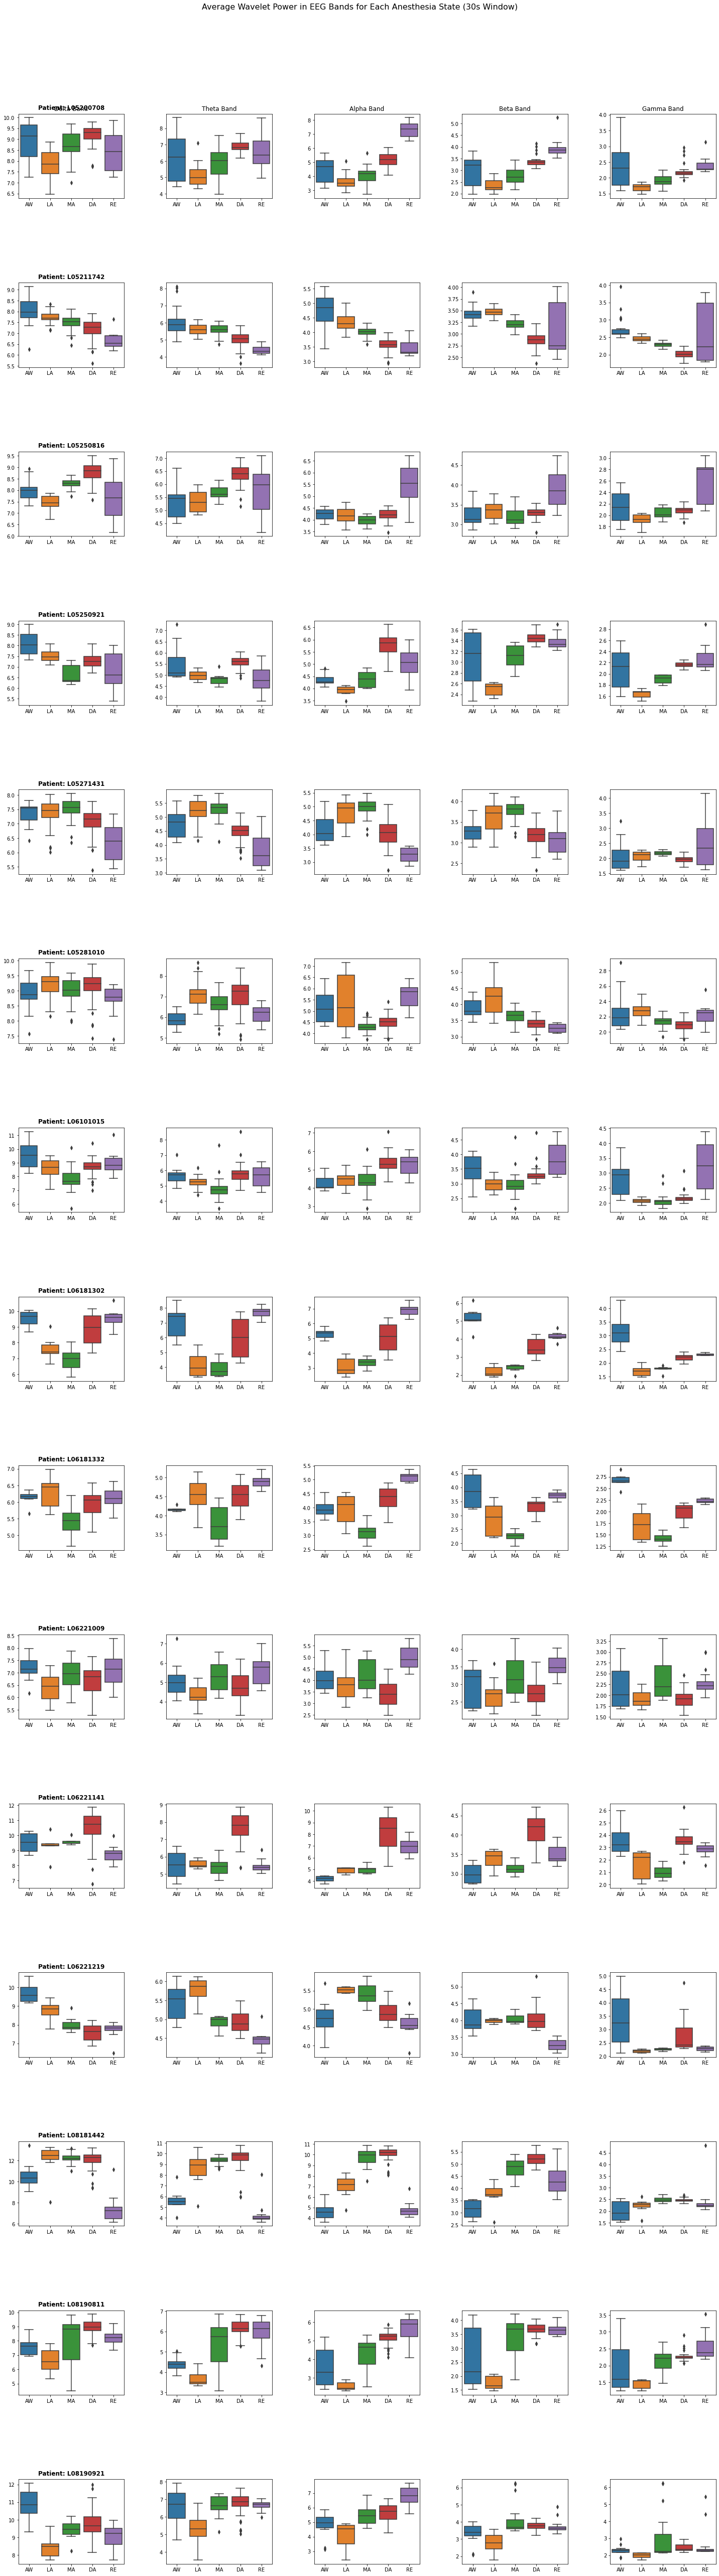

In [56]:
# Function to calculate average power within a frequency band
def calculate_band_power(frequencies, avg_coefficients, band):
    band_min, band_max = band
    band_indices = np.where((frequencies >= band_min) & (frequencies <= band_max))
    band_power = np.mean(avg_coefficients[band_indices])
    return band_power

# Define scales
scales = np.arange(1, 128)

# Create an empty DataFrame to store results
wavelet_power_df = pd.DataFrame(columns=['Patient', 'State', 'Band', 'Power'])

sampling_freq = 128  # Hz
window_size = 30 * sampling_freq  # 30-second window in samples

# Loop through patients and states to calculate average wavelet power for each band
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']  # Load EEG data
    labels = globals()[f'{patient}_label']  # Load state labels
    
    for start, end, label in labels:
        for i in range(start, end, window_size):
            if i + window_size > end:
                break  # Skip the last incomplete window if any
            state_eeg = eeg_data['eeg'][i:i+window_size].values
            
            # Calculate wavelet transform and average coefficients for the window
            frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
            
            # Calculate the average power in each band
            for band_name, band_range in eeg_bands.items():
                band_power = calculate_band_power(frequencies, avg_coefficients, band_range)
                
                # Append to the DataFrame
                new_row = pd.DataFrame({
                    'Patient': [patient],
                    'State': [label],
                    'Band': [band_name],
                    'Power': [band_power]
                })
                
                wavelet_power_df = pd.concat([wavelet_power_df, new_row], ignore_index=True)

# Number of patients and bands
num_patients = len(patient_list)
num_bands = len(eeg_bands)

# Create a grid of subplots with 15 rows (patients) and 5 columns (bands)
fig, axes = plt.subplots(nrows=num_patients, ncols=num_bands, figsize=(20, 5*num_patients))

# Flatten axes for easier access
axes = axes.reshape(num_patients, num_bands)

# Loop through each patient and plot the wavelet power in each EEG band
for row_idx, patient in enumerate(patient_list):
    for col_idx, (band_name, _) in enumerate(eeg_bands.items()):
        band_data = wavelet_power_df[(wavelet_power_df['Patient'] == patient) & (wavelet_power_df['Band'] == band_name)]
        
        sns.boxplot(ax=axes[row_idx, col_idx], x='State', y='Power', data=band_data)
        
        if row_idx == 0:
            axes[row_idx, col_idx].set_title(f'{band_name} Band')
        axes[row_idx, col_idx].set_xlabel('') 
        axes[row_idx, col_idx].set_ylabel('')
    
    # Add patient ID label in the first plot of each row
    axes[row_idx, 0].annotate(f'Patient: {patient}', xy=(0.5, 1.05), xycoords='axes fraction', ha='center', fontsize=12, fontweight='bold')

plt.suptitle('Average Wavelet Power in EEG Bands for Each Anesthesia State (30s Window)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=1.0, wspace=0.4)
plt.show()

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

# Define EEG bands in Hz
eeg_bands = {
    "Delta": (0, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 49)
}

# Function to calculate average power within a frequency band
def calculate_band_power(frequencies, avg_coefficients, band):
    band_min, band_max = band
    # Find indices corresponding to the band range
    band_indices = np.where((frequencies >= band_min) & (frequencies <= band_max))
    # Calculate the average power within this band
    band_power = np.mean(avg_coefficients[band_indices])
    return band_power

# Calculate shannon entropy
def shannon_entropy(signal, num_bins=10):
    hist, _ = np.histogram(signal, bins=num_bins, density=True)
    probs = hist / np.sum(hist)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

# Create empty lists to store features and labels
features = []
labels = []

# Define scales (this will correspond to frequency bands for the wavelet transform)
scales = np.arange(1, 128)

# Sampling frequency of EEG (assumed to be 128 Hz, modify as needed)
sampling_freq = 128  # Hz
window_size = 30 * sampling_freq  # 30-second window in samples

# Loop through patients and states to calculate band power and entropy for each window
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']  # Load EEG data
    labels_data = globals()[f'{patient}_label']  # Load state labels
    
    for start, end, label in labels_data:
        # Segment EEG data into 30-second windows
        for i in range(start, end, window_size):
            if i + window_size > end:
                break  # Skip the last incomplete window if any
            state_eeg = eeg_data['eeg'][i:i+window_size].values
            
            # Calculate wavelet transform and average coefficients for the window
            frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
            
            # Calculate the average power in each band
            band_powers = []
            for band_name, band_range in eeg_bands.items():
                band_power = calculate_band_power(frequencies, avg_coefficients, band_range)
                band_powers.append(band_power)
            
            # Calculate entropy for the window
            entropy_value = shannon_entropy(state_eeg)
            
            # Combine band powers and entropy into a feature vector
            feature_vector = band_powers + [entropy_value]
            
            # Append the feature vector and label to the respective lists
            features.append(feature_vector)
            labels.append(label)

# Convert the features and labels into a DataFrame for further processing
features_df = pd.DataFrame(features, columns=["Delta", "Theta", "Alpha", "Beta", "Gamma", "Entropy"])
labels_df = pd.Series(labels, name="State")

# Encode the labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_df)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features_df, y_encoded, test_size=0.2, random_state=42)

# Initialize and train KNN classifier (same settings as in Tai's paper, adjust k as needed)
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # Adjust the number of neighbors as per your reference
knn_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.2f}")


Accuracy: 64.65%
F1 Score: 0.63


## Normalised

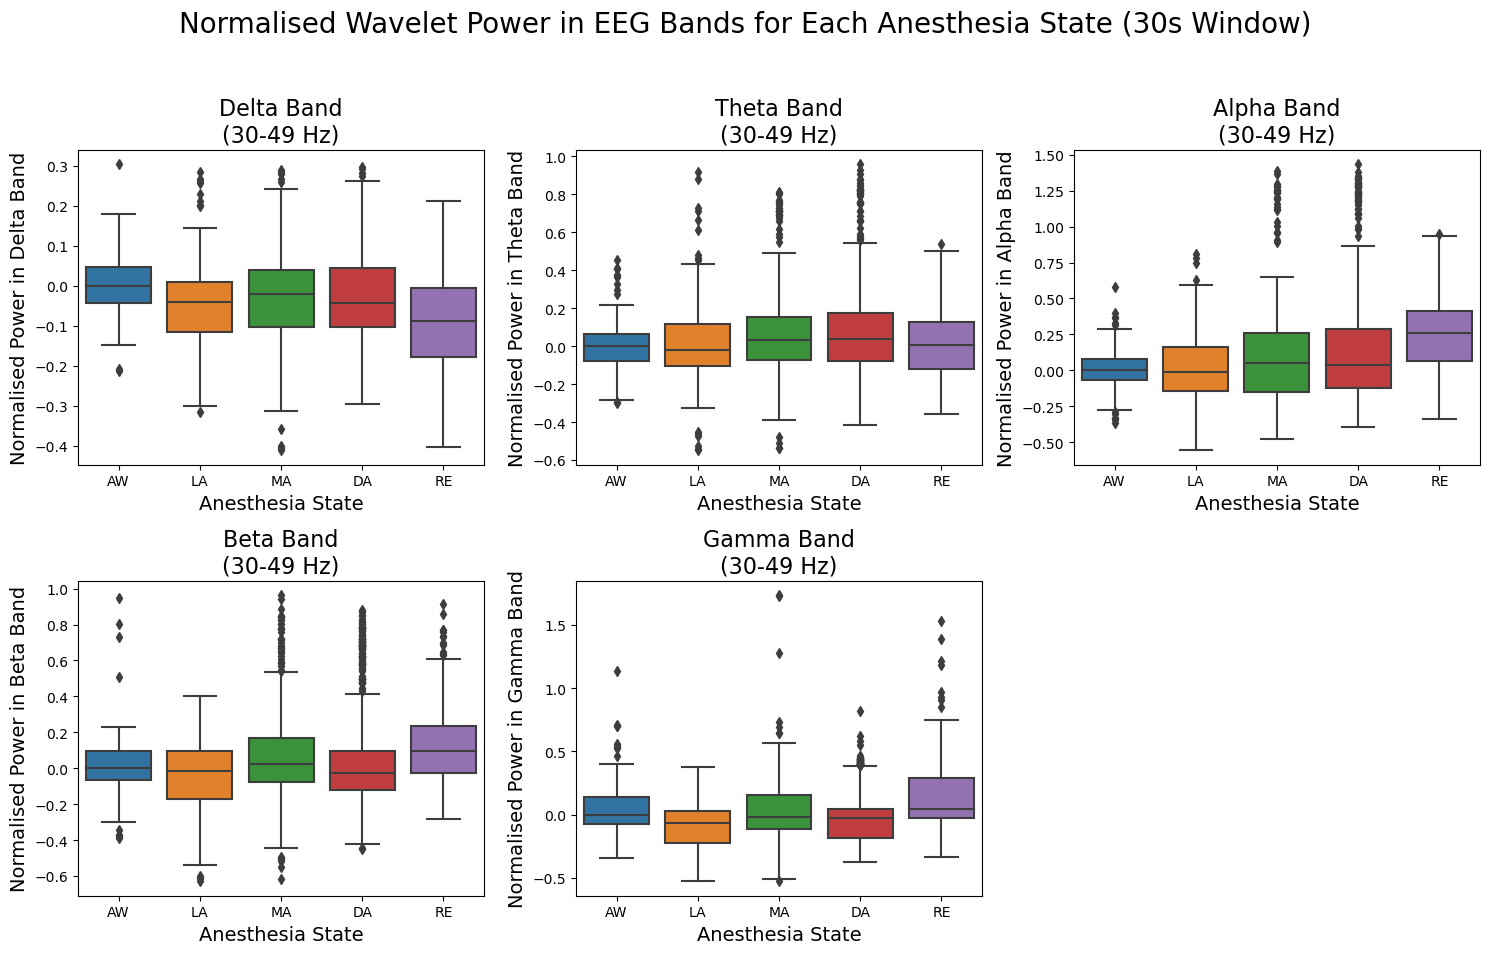

In [110]:
# Create an empty DataFrame to store normalized results
normalized_wavelet_power_df = pd.DataFrame(columns=['Patient', 'State', 'Band', 'Power'])

# Loop through each patient and band to normalize the power values
for patient in patient_list:
    for band_name in eeg_bands.keys():
        # Get the median power for the AW (Awake) state for this patient and band
        awake_data = wavelet_power_df[
            (wavelet_power_df['Patient'] == patient) & 
            (wavelet_power_df['Band'] == band_name) & 
            (wavelet_power_df['State'] == 'AW')
        ]
        
        if not awake_data.empty:
            median_awake_power = awake_data['Power'].median()

            # Normalize the power values across all states by the median of the AW state
            patient_band_data = wavelet_power_df[
                (wavelet_power_df['Patient'] == patient) & (wavelet_power_df['Band'] == band_name)
            ].copy()
            
            # Apply the normalization formula
            patient_band_data['Power'] = (patient_band_data['Power'] - median_awake_power) / median_awake_power

            # Append to the normalized DataFrame
            normalized_wavelet_power_df = pd.concat([normalized_wavelet_power_df, patient_band_data], ignore_index=True)

# Now you can plot the normalized data, just like the original data
# Plot all bands in a grid of 3 plots in the first row and 2 plots in the second row
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust figsize for smaller plots

# Flatten axes for easier access
axes = axes.flatten()

# Remove the last (6th) subplot as we only need 5 plots
fig.delaxes(axes[5])

# Plot each EEG band
for idx, (band_name, _) in enumerate(eeg_bands.items()):
    # Filter the normalized data for the current band
    band_data = normalized_wavelet_power_df[normalized_wavelet_power_df['Band'] == band_name]
    
    # Create the box plot in the appropriate subplot
    sns.boxplot(ax=axes[idx], x='State', y='Power', data=band_data)
    
    # Customize each subplot
    axes[idx].set_title(f'{band_name} Band\n({band_range[0]}-{band_range[1]} Hz)', fontsize=16)
    axes[idx].set_xlabel('Anesthesia State', fontsize=14)
    axes[idx].set_ylabel(f'Normalised Power in {band_name} Band', fontsize=14)

# Add an overall title for the entire figure
plt.suptitle('Normalised Wavelet Power in EEG Bands for Each Anesthesia State (30s Window)', fontsize=20)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()


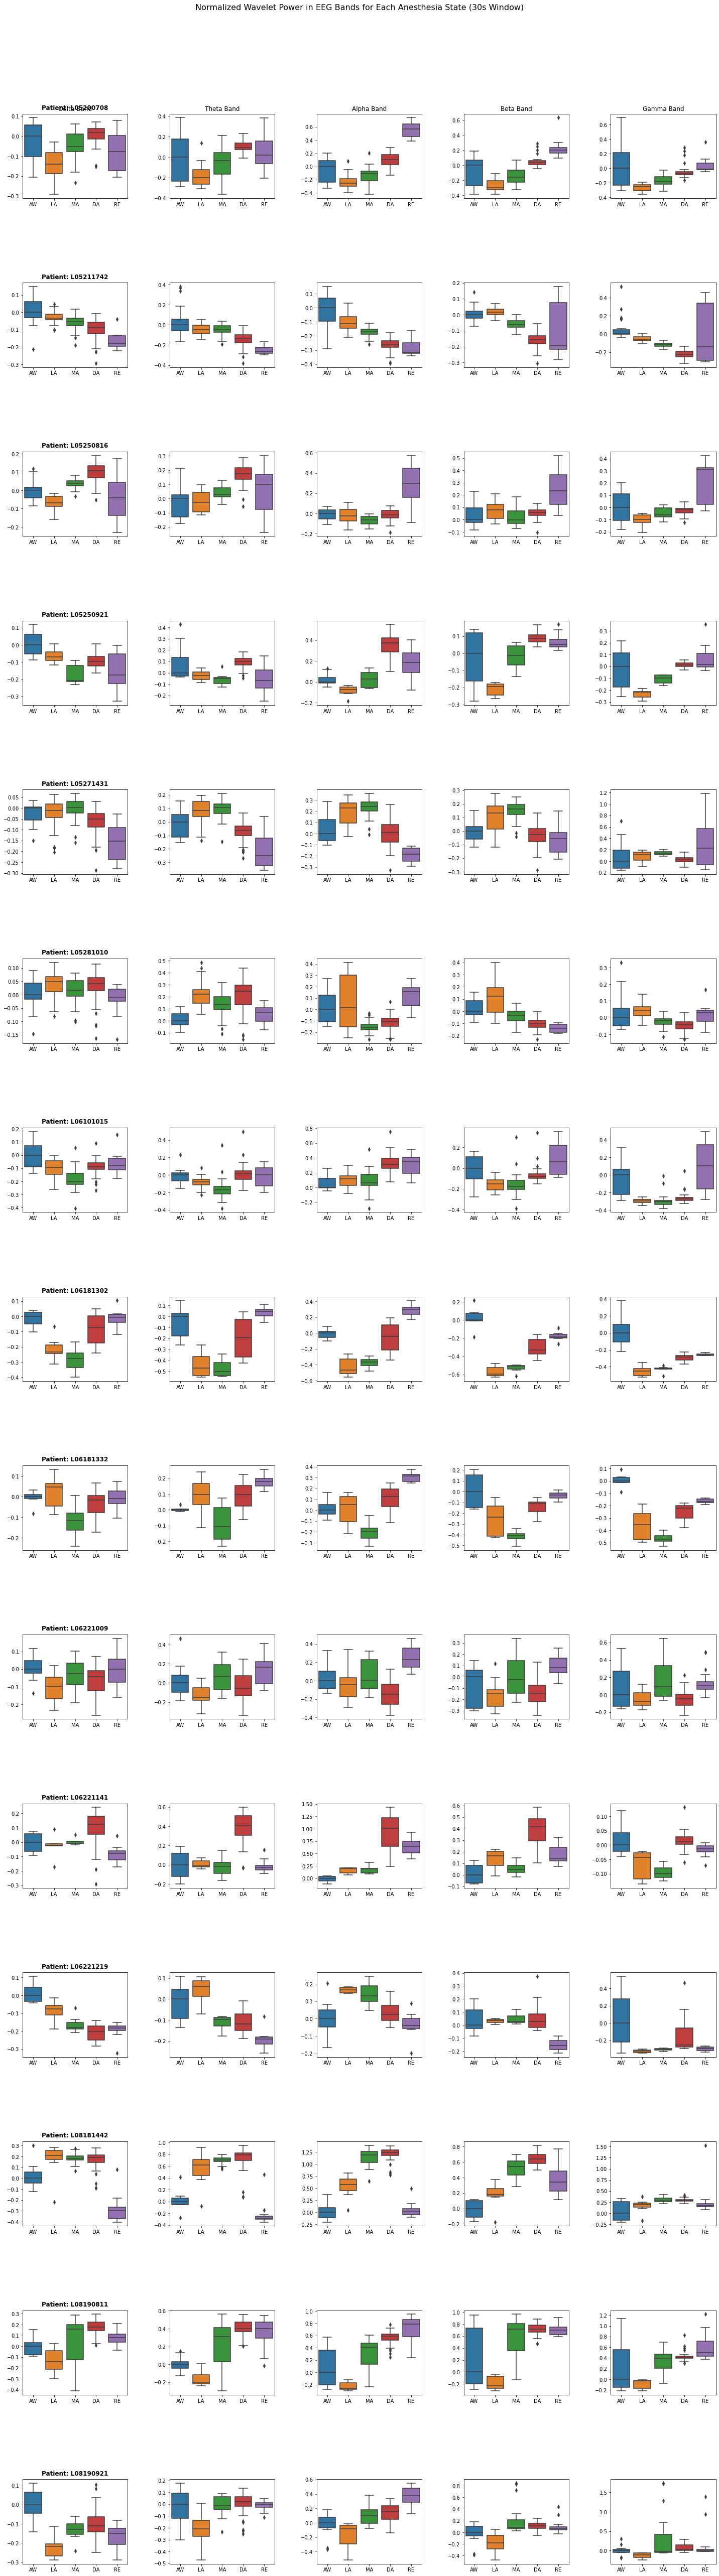

In [58]:
# Function to calculate average power within a frequency band
def calculate_band_power(frequencies, avg_coefficients, band):
    band_min, band_max = band
    band_indices = np.where((frequencies >= band_min) & (frequencies <= band_max))
    band_power = np.mean(avg_coefficients[band_indices])
    return band_power

# Define scales
scales = np.arange(1, 128)

# Create an empty DataFrame to store results
wavelet_power_df = pd.DataFrame(columns=['Patient', 'State', 'Band', 'Power'])

sampling_freq = 128  # Hz
window_size = 30 * sampling_freq  # 30-second window in samples

# Loop through patients and states to calculate average wavelet power for each band
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']  # Load EEG data
    labels = globals()[f'{patient}_label']  # Load state labels
    
    for start, end, label in labels:
        for i in range(start, end, window_size):
            if i + window_size > end:
                break  # Skip the last incomplete window if any
            state_eeg = eeg_data['eeg'][i:i+window_size].values
            
            # Calculate wavelet transform and average coefficients for the window
            frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
            
            # Calculate the average power in each band
            for band_name, band_range in eeg_bands.items():
                band_power = calculate_band_power(frequencies, avg_coefficients, band_range)
                
                # Append to the DataFrame
                new_row = pd.DataFrame({
                    'Patient': [patient],
                    'State': [label],
                    'Band': [band_name],
                    'Power': [band_power]
                })
                
                wavelet_power_df = pd.concat([wavelet_power_df, new_row], ignore_index=True)

# Normalization Step
normalized_wavelet_power_df = pd.DataFrame(columns=['Patient', 'State', 'Band', 'Power'])

for patient in patient_list:
    for band_name in eeg_bands.keys():
        # Get the median power for the awake state for each patient and band
        median_aw_power = wavelet_power_df[
            (wavelet_power_df['Patient'] == patient) &
            (wavelet_power_df['Band'] == band_name) &
            (wavelet_power_df['State'] == 'AW')
        ]['Power'].median()
        
        # Normalize the power values for this patient and band
        patient_band_data = wavelet_power_df[
            (wavelet_power_df['Patient'] == patient) & (wavelet_power_df['Band'] == band_name)
        ].copy()
        
        # Apply normalization
        patient_band_data['Power'] = (patient_band_data['Power'] - median_aw_power) / median_aw_power
        
        # Append normalized data to new DataFrame
        normalized_wavelet_power_df = pd.concat([normalized_wavelet_power_df, patient_band_data], ignore_index=True)

# Plot the normalized data
num_patients = len(patient_list)
num_bands = len(eeg_bands)

fig, axes = plt.subplots(nrows=num_patients, ncols=num_bands, figsize=(20, 5*num_patients))

# Flatten axes for easier access
axes = axes.reshape(num_patients, num_bands)

# Loop through each patient and plot the normalized wavelet power in each EEG band
for row_idx, patient in enumerate(patient_list):
    for col_idx, band_name in enumerate(eeg_bands.keys()):
        # Filter the normalized data for the current patient and band
        band_data = normalized_wavelet_power_df[
            (normalized_wavelet_power_df['Patient'] == patient) & 
            (normalized_wavelet_power_df['Band'] == band_name)
        ]
        
        sns.boxplot(ax=axes[row_idx, col_idx], x='State', y='Power', data=band_data)
        
        if row_idx == 0:
            axes[row_idx, col_idx].set_title(f'{band_name} Band')
        axes[row_idx, col_idx].set_xlabel('') 
        axes[row_idx, col_idx].set_ylabel('')
    
    # Add patient ID label in the first plot of each row
    axes[row_idx, 0].annotate(f'Patient: {patient}', xy=(0.5, 1.05), xycoords='axes fraction', ha='center', fontsize=12, fontweight='bold')

plt.suptitle('Normalized Wavelet Power in EEG Bands for Each Anesthesia State (30s Window)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=1.0, wspace=0.4)
plt.show()


### KNN

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import xgboost as xgb
import pandas as pd

# Define EEG bands in Hz
eeg_bands = {
    "Delta": (0, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 49)
}

# Function to calculate average power within a frequency band
def calculate_band_power(frequencies, avg_coefficients, band):
    band_min, band_max = band
    band_indices = np.where((frequencies >= band_min) & (frequencies <= band_max))
    band_power = np.mean(avg_coefficients[band_indices])
    return band_power

# Calculate Shannon entropy
def shannon_entropy(signal, num_bins=10):
    hist, _ = np.histogram(signal, bins=num_bins, density=True)
    probs = hist / np.sum(hist)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

# Create empty lists to store features and labels
features = []
labels = []

# Create dictionaries to store median values for entropy and power in the AW state
median_awake_entropy = {}
median_awake_power = {patient: {} for patient in patient_list}

# Define scales for continuous wavelet transform
scales = np.arange(1, 128)

# Sampling frequency of EEG (assumed to be 128 Hz, modify as needed)
sampling_freq = 128  # Hz
window_size = 30 * sampling_freq  # 30-second window in samples

# First pass: Calculate median entropy and band power for the AW state for each patient
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']  # Load EEG data
    labels_data = globals()[f'{patient}_label']  # Load state labels
    
    # Store entropy and band power values for normalization
    awake_entropies = {band_name: [] for band_name in eeg_bands.keys()}
    awake_entropies['Entropy'] = []  # Store entropy for normalization
    
    for start, end, label in labels_data:
        if label == 'AW':  # Only process awake state (AW)
            for i in range(start, end, window_size):
                if i + window_size > end:
                    break
                state_eeg = eeg_data['eeg'][i:i + window_size].values
                frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
                
                # Calculate entropy and add to the list
                entropy_value = shannon_entropy(state_eeg)
                awake_entropies['Entropy'].append(entropy_value)
                
                # Calculate power for each band
                for band_name, band_range in eeg_bands.items():
                    band_power = calculate_band_power(frequencies, avg_coefficients, band_range)
                    awake_entropies[band_name].append(band_power)
    
    # Calculate and store median entropy and band power for AW state
    if len(awake_entropies['Entropy']) > 0:
        median_awake_entropy[patient] = np.median(awake_entropies['Entropy'])
    else:
        median_awake_entropy[patient] = None
    
    # Store median power for each band
    for band_name in eeg_bands.keys():
        if len(awake_entropies[band_name]) > 0:
            median_awake_power[patient][band_name] = np.median(awake_entropies[band_name])
        else:
            median_awake_power[patient][band_name] = None

# Second pass: Normalise band power and entropy for all states
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']  # Load EEG data
    labels_data = globals()[f'{patient}_label']  # Load state labels
    
    for start, end, label in labels_data:
        for i in range(start, end, window_size):
            if i + window_size > end:
                break
            state_eeg = eeg_data['eeg'][i:i + window_size].values
            frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
            
            # Normalise the band power values
            band_powers = []
            for band_name, band_range in eeg_bands.items():
                band_power = calculate_band_power(frequencies, avg_coefficients, band_range)
                # Normalise by the median power in AW state
                if median_awake_power[patient][band_name] is not None and median_awake_power[patient][band_name] != 0:
                    normalized_band_power = (band_power - median_awake_power[patient][band_name]) / median_awake_power[patient][band_name]
                else:
                    normalized_band_power = band_power
                band_powers.append(normalized_band_power)
            
            # Calculate and normalize entropy
            entropy_value = shannon_entropy(state_eeg)
            if median_awake_entropy[patient] is not None and median_awake_entropy[patient] != 0:
                normalized_entropy = (entropy_value - median_awake_entropy[patient]) / median_awake_entropy[patient]
            else:
                normalized_entropy = entropy_value
            
            # Combine normalized band powers and entropy into a feature vector
            feature_vector = band_powers + [normalized_entropy]
            features.append(feature_vector)
            labels.append(label)

# Convert features and labels into DataFrame
features_df = pd.DataFrame(features, columns=["Delta", "Theta", "Alpha", "Beta", "Gamma", "Entropy"])
labels_df = pd.Series(labels, name="State")

# Encode the labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_df)

# First, split the data into 70% training and 30% temp set (for validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(features_df, y_encoded, test_size=0.3, random_state=42)

# Then, split the temp set into 2/3 validation (20%) and 1/3 test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1/3), random_state=42)

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier on the training set
knn_classifier.fit(X_train, y_train)

# Validate the model on the validation set
y_val_pred = knn_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

# Test the model on the test set
y_test_pred = knn_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print evaluation metrics
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation F1 Score: {val_f1:.2f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test F1 Score: {test_f1:.2f}")

Validation Accuracy: 67.27%
Validation F1 Score: 0.66
Test Accuracy: 68.67%
Test F1 Score: 0.67


### LOPOCV

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

# Define EEG bands in Hz
eeg_bands = {
    "Delta": (0, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 49)
}

# Function to calculate average power within a frequency band
def calculate_band_power(frequencies, avg_coefficients, band):
    band_min, band_max = band
    band_indices = np.where((frequencies >= band_min) & (frequencies <= band_max))
    band_power = np.mean(avg_coefficients[band_indices])
    return band_power

# Calculate Shannon entropy
def shannon_entropy(signal, num_bins=10):
    hist, _ = np.histogram(signal, bins=num_bins, density=True)
    probs = hist / np.sum(hist)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

# Create empty lists to store features, labels, and patient IDs
features = []
labels = []
patient_ids = []

# Create dictionaries to store median values for entropy and power in the AW state
median_awake_entropy = {}
median_awake_power = {patient: {} for patient in patient_list}

# Define scales for continuous wavelet transform
scales = np.arange(1, 128)

# Sampling frequency of EEG (assumed to be 128 Hz, modify as needed)
sampling_freq = 128  # Hz
window_size = 30 * sampling_freq  # 30-second window in samples

# First pass: Calculate median entropy and band power for the AW state for each patient
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']  # Load EEG data
    labels_data = globals()[f'{patient}_label']  # Load state labels
    
    # Store entropy and band power values for normalization
    awake_entropies = {band_name: [] for band_name in eeg_bands.keys()}
    awake_entropies['Entropy'] = []  # Store entropy for normalization
    
    for start, end, label in labels_data:
        if label == 'AW':  # Only process awake state (AW)
            for i in range(start, end, window_size):
                if i + window_size > end:
                    break
                state_eeg = eeg_data['eeg'][i:i + window_size].values
                frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
                
                # Calculate entropy and add to the list
                entropy_value = shannon_entropy(state_eeg)
                awake_entropies['Entropy'].append(entropy_value)
                
                # Calculate power for each band
                for band_name, band_range in eeg_bands.items():
                    band_power = calculate_band_power(frequencies, avg_coefficients, band_range)
                    awake_entropies[band_name].append(band_power)
    
    # Calculate and store median entropy and band power for AW state
    if len(awake_entropies['Entropy']) > 0:
        median_awake_entropy[patient] = np.median(awake_entropies['Entropy'])
    else:
        median_awake_entropy[patient] = None
    
    # Store median power for each band
    for band_name in eeg_bands.keys():
        if len(awake_entropies[band_name]) > 0:
            median_awake_power[patient][band_name] = np.median(awake_entropies[band_name])
        else:
            median_awake_power[patient][band_name] = None

# Second pass: Normalise band power and entropy for all states
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']  # Load EEG data
    labels_data = globals()[f'{patient}_label']  # Load state labels
    
    for start, end, label in labels_data:
        for i in range(start, end, window_size):
            if i + window_size > end:
                break
            state_eeg = eeg_data['eeg'][i:i + window_size].values
            frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
            
            # Normalise the band power values
            band_powers = []
            for band_name, band_range in eeg_bands.items():
                band_power = calculate_band_power(frequencies, avg_coefficients, band_range)
                # Normalise by the median power in AW state
                if median_awake_power[patient][band_name] is not None and median_awake_power[patient][band_name] != 0:
                    normalized_band_power = (band_power - median_awake_power[patient][band_name]) / median_awake_power[patient][band_name]
                else:
                    normalized_band_power = band_power
                band_powers.append(normalized_band_power)
            
            # Calculate and normalize entropy
            entropy_value = shannon_entropy(state_eeg)
            if median_awake_entropy[patient] is not None and median_awake_entropy[patient] != 0:
                normalized_entropy = (entropy_value - median_awake_entropy[patient]) / median_awake_entropy[patient]
            else:
                normalized_entropy = entropy_value
            
            # Combine normalized band powers and entropy into a feature vector
            feature_vector = band_powers + [normalized_entropy]
            features.append(feature_vector)
            labels.append(label)
            patient_ids.append(patient)  # Store the patient ID for LOPOCV

# Convert features and labels into DataFrame
features_df = pd.DataFrame(features, columns=["Delta", "Theta", "Alpha", "Beta", "Gamma", "Entropy"])
labels_df = pd.Series(labels, name="State")

# Encode the labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_df)

# Initialize the Leave-One-Group-Out (LOPOCV) cross-validator
logo = LeaveOneGroupOut()

# Initialise variables to store results and per-patient scores
all_preds = []
all_labels = []
patient_scores = {}

# Loop over each patient (leave one patient out)
for train_idx, test_idx in logo.split(features_df, y_encoded, groups=patient_ids):
    # Split the data into training and testing sets based on the patient IDs
    X_train, X_test = features_df.iloc[train_idx], features_df.iloc[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
    
    # Initialise the KNN classifier 
    knn_classifier = KNeighborsClassifier(n_neighbors=10)
    
    # Train the classifier
    knn_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = knn_classifier.predict(X_test)
    
    # Store predictions and true labels
    all_preds.extend(y_pred)
    all_labels.extend(y_test)
    
    # Calculate accuracy and F1 score for the left-out patient
    patient_accuracy = accuracy_score(y_test, y_pred)
    patient_f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Save the scores for this patient
    patient_id = patient_ids[test_idx[0]]  # Get the patient ID
    patient_scores[patient_id] = {"Accuracy": patient_accuracy, "F1 Score": patient_f1}
    patient_scores.append({
        "Patient_ID": patient_id,
        "Accuracy": patient_accuracy,
        "F1_Score": patient_f1
    })    

# Evaluate the overall model performance across all patients
overall_accuracy = accuracy_score(all_labels, all_preds)
overall_f1 = f1_score(all_labels, all_preds, average='weighted')

patient_scores_df = pd.DataFrame(patient_scores)
patient_scores_df.to_csv('wavelet_knn_lopocv.csv', index=False)

# Print overall results
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Overall F1 Score: {overall_f1:.2f}")

# Print individual patient scores
for patient, scores in patient_scores.items():
    print(f"Patient {patient} - Accuracy: {scores['Accuracy'] * 100:.2f}%, F1 Score: {scores['F1 Score']:.2f}")


Overall Accuracy: 38.04%
Overall F1 Score: 0.37
Patient L05200708 - Accuracy: 34.78%, F1 Score: 0.33
Patient L05211742 - Accuracy: 48.40%, F1 Score: 0.44
Patient L05250816 - Accuracy: 53.76%, F1 Score: 0.53
Patient L05250921 - Accuracy: 40.79%, F1 Score: 0.39
Patient L05271431 - Accuracy: 23.04%, F1 Score: 0.22
Patient L05281010 - Accuracy: 59.55%, F1 Score: 0.55
Patient L06101015 - Accuracy: 21.85%, F1 Score: 0.20
Patient L06181302 - Accuracy: 24.39%, F1 Score: 0.21
Patient L06181332 - Accuracy: 33.33%, F1 Score: 0.32
Patient L06221009 - Accuracy: 29.09%, F1 Score: 0.28
Patient L06221141 - Accuracy: 25.93%, F1 Score: 0.27
Patient L06221219 - Accuracy: 21.95%, F1 Score: 0.22
Patient L08181442 - Accuracy: 52.69%, F1 Score: 0.44
Patient L08190811 - Accuracy: 39.66%, F1 Score: 0.38
Patient L08190921 - Accuracy: 35.92%, F1 Score: 0.38


In [75]:
patient_scores = [
    {"Patient_ID": "L05200708", "Accuracy": 34.78, "F1_Score": 0.33},
    {"Patient_ID": "L05211742", "Accuracy": 48.40, "F1_Score": 0.44},
    {"Patient_ID": "L05250816", "Accuracy": 53.76, "F1_Score": 0.53},
    {"Patient_ID": "L05250921", "Accuracy": 40.79, "F1_Score": 0.39},
    {"Patient_ID": "L05271431", "Accuracy": 23.04, "F1_Score": 0.22},
    {"Patient_ID": "L05281010", "Accuracy": 59.55, "F1_Score": 0.55},
    {"Patient_ID": "L06101015", "Accuracy": 21.85, "F1_Score": 0.20},
    {"Patient_ID": "L06181302", "Accuracy": 24.39, "F1_Score": 0.21},
    {"Patient_ID": "L06181332", "Accuracy": 33.33, "F1_Score": 0.32},
    {"Patient_ID": "L06221009", "Accuracy": 29.09, "F1_Score": 0.28},
    {"Patient_ID": "L06221141", "Accuracy": 25.93, "F1_Score": 0.27},
    {"Patient_ID": "L06221219", "Accuracy": 21.95, "F1_Score": 0.22},
    {"Patient_ID": "L08181442", "Accuracy": 52.69, "F1_Score": 0.44},
    {"Patient_ID": "L08190811", "Accuracy": 39.66, "F1_Score": 0.38},
    {"Patient_ID": "L08190921", "Accuracy": 35.92, "F1_Score": 0.38}
]

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(patient_scores)

# Save the DataFrame to a CSV file
df.to_csv("wavelet_result/knn_result.csv", index=False)

## XGBoost

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import xgboost as xgb
import pandas as pd

# Define EEG bands in Hz
eeg_bands = {
    "Delta": (0, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 49)
}

# Function to calculate average power within a frequency band
def calculate_band_power(frequencies, avg_coefficients, band):
    band_min, band_max = band
    band_indices = np.where((frequencies >= band_min) & (frequencies <= band_max))
    band_power = np.mean(avg_coefficients[band_indices])
    return band_power

# Calculate Shannon entropy
def shannon_entropy(signal, num_bins=10):
    hist, _ = np.histogram(signal, bins=num_bins, density=True)
    probs = hist / np.sum(hist)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

# Create empty lists to store features and labels
features = []
labels = []

# Create dictionaries to store median values for entropy and power in the AW state
median_awake_entropy = {}
median_awake_power = {patient: {} for patient in patient_list}

# Define scales for continuous wavelet transform
scales = np.arange(1, 128)

# Sampling frequency of EEG (assumed to be 128 Hz, modify as needed)
sampling_freq = 128  # Hz
window_size = 30 * sampling_freq  # 30-second window in samples

# First pass: Calculate median entropy and band power for the AW state for each patient
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']  # Load EEG data
    labels_data = globals()[f'{patient}_label']  # Load state labels
    
    # Store entropy and band power values for normalization
    awake_entropies = {band_name: [] for band_name in eeg_bands.keys()}
    awake_entropies['Entropy'] = []  # Store entropy for normalization
    
    for start, end, label in labels_data:
        if label == 'AW':  # Only process awake state (AW)
            for i in range(start, end, window_size):
                if i + window_size > end:
                    break
                state_eeg = eeg_data['eeg'][i:i + window_size].values
                frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
                
                # Calculate entropy and add to the list
                entropy_value = shannon_entropy(state_eeg)
                awake_entropies['Entropy'].append(entropy_value)
                
                # Calculate power for each band
                for band_name, band_range in eeg_bands.items():
                    band_power = calculate_band_power(frequencies, avg_coefficients, band_range)
                    awake_entropies[band_name].append(band_power)
    
    # Calculate and store median entropy and band power for AW state
    if len(awake_entropies['Entropy']) > 0:
        median_awake_entropy[patient] = np.median(awake_entropies['Entropy'])
    else:
        median_awake_entropy[patient] = None
    
    # Store median power for each band
    for band_name in eeg_bands.keys():
        if len(awake_entropies[band_name]) > 0:
            median_awake_power[patient][band_name] = np.median(awake_entropies[band_name])
        else:
            median_awake_power[patient][band_name] = None

# Second pass: Normalise band power and entropy for all states
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']  # Load EEG data
    labels_data = globals()[f'{patient}_label']  # Load state labels
    
    for start, end, label in labels_data:
        for i in range(start, end, window_size):
            if i + window_size > end:
                break
            state_eeg = eeg_data['eeg'][i:i + window_size].values
            frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
            
            # Normalise the band power values
            band_powers = []
            for band_name, band_range in eeg_bands.items():
                band_power = calculate_band_power(frequencies, avg_coefficients, band_range)
                # Normalise by the median power in AW state
                if median_awake_power[patient][band_name] is not None and median_awake_power[patient][band_name] != 0:
                    normalized_band_power = (band_power - median_awake_power[patient][band_name]) / median_awake_power[patient][band_name]
                else:
                    normalized_band_power = band_power
                band_powers.append(normalized_band_power)
            
            # Calculate and normalize entropy
            entropy_value = shannon_entropy(state_eeg)
            if median_awake_entropy[patient] is not None and median_awake_entropy[patient] != 0:
                normalized_entropy = (entropy_value - median_awake_entropy[patient]) / median_awake_entropy[patient]
            else:
                normalized_entropy = entropy_value
            
            # Combine normalized band powers and entropy into a feature vector
            feature_vector = band_powers + [normalized_entropy]
            features.append(feature_vector)
            labels.append(label)

# Convert features and labels into DataFrame
features_df = pd.DataFrame(features, columns=["Delta", "Theta", "Alpha", "Beta", "Gamma", "Entropy"])
labels_df = pd.Series(labels, name="State")

# Encode the labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_df)

# Step 1: First, split the data into 70% training and 30% temporary set
X_train, X_temp, y_train, y_temp = train_test_split(features_df, y_encoded, test_size=0.3, random_state=42)

# Step 2: Split the temporary set into 2/3 validation (20%) and 1/3 test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1/3), random_state=42)

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=500,
    gamma=0.1,             
    min_child_weight=3,     
    alpha=0.5,              
    eval_metric='mlogloss', 
    random_state=2)

# Train the XGBoost model on the training set
xgb_classifier.fit(X_train, y_train)

# Validate the model on the validation set
y_val_pred = xgb_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

# Test the model on the test set
y_test_pred = xgb_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print validation and test metrics
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation F1 Score: {val_f1:.2f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test F1 Score: {test_f1:.2f}")

Validation Accuracy: 66.97%
Validation F1 Score: 0.66
Test Accuracy: 62.65%
Test F1 Score: 0.63


## LOPOCV

In [53]:
import xgboost as xgb
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

# Create empty lists to store features, labels, and patient IDs
features = []
labels = []
patient_ids = []

# Create dictionaries to store median values for entropy and power in the AW state
median_awake_entropy = {}
median_awake_power = {patient: {} for patient in patient_list}

# Define scales for continuous wavelet transform
scales = np.arange(1, 128)

# Sampling frequency of EEG (assumed to be 128 Hz)
sampling_freq = 128  # Hz
window_size = 30 * sampling_freq  # 30-second window in samples

# First pass: Calculate median entropy and band power for the AW state for each patient
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']  # Load EEG data
    labels_data = globals()[f'{patient}_label']  # Load state labels
    
    # Store entropy and band power values for normalization
    awake_entropies = {band_name: [] for band_name in eeg_bands.keys()}
    awake_entropies['Entropy'] = []  # Store entropy for normalization
    
    for start, end, label in labels_data:
        if label == 'AW':  # Only process awake state (AW)
            for i in range(start, end, window_size):
                if i + window_size > end:
                    break
                state_eeg = eeg_data['eeg'][i:i + window_size].values
                frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
                
                # Calculate entropy and add to the list
                entropy_value = shannon_entropy(state_eeg)
                awake_entropies['Entropy'].append(entropy_value)
                
                # Calculate power for each band
                for band_name, band_range in eeg_bands.items():
                    band_power = calculate_band_power(frequencies, avg_coefficients, band_range)
                    awake_entropies[band_name].append(band_power)
    
    # Calculate and store median entropy and band power for AW state
    if len(awake_entropies['Entropy']) > 0:
        median_awake_entropy[patient] = np.median(awake_entropies['Entropy'])
    else:
        median_awake_entropy[patient] = None
    
    # Store median power for each band
    for band_name in eeg_bands.keys():
        if len(awake_entropies[band_name]) > 0:
            median_awake_power[patient][band_name] = np.median(awake_entropies[band_name])
        else:
            median_awake_power[patient][band_name] = None

# Second pass: Normalise band power and entropy for all states
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']  # Load EEG data
    labels_data = globals()[f'{patient}_label']  # Load state labels
    
    for start, end, label in labels_data:
        for i in range(start, end, window_size):
            if i + window_size > end:
                break
            state_eeg = eeg_data['eeg'][i:i + window_size].values
            frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
            
            # Normalise the band power values
            band_powers = []
            for band_name, band_range in eeg_bands.items():
                band_power = calculate_band_power(frequencies, avg_coefficients, band_range)
                # Normalise by the median power in AW state
                if median_awake_power[patient][band_name] is not None and median_awake_power[patient][band_name] != 0:
                    normalized_band_power = (band_power - median_awake_power[patient][band_name]) / median_awake_power[patient][band_name]
                else:
                    normalized_band_power = band_power
                band_powers.append(normalized_band_power)
            
            # Calculate and normalize entropy
            entropy_value = shannon_entropy(state_eeg)
            if median_awake_entropy[patient] is not None and median_awake_entropy[patient] != 0:
                normalized_entropy = (entropy_value - median_awake_entropy[patient]) / median_awake_entropy[patient]
            else:
                normalized_entropy = entropy_value
            
            # Combine normalized band powers and entropy into a feature vector
            feature_vector = band_powers + [normalized_entropy]
            features.append(feature_vector)
            labels.append(label)
            patient_ids.append(patient)  # Store the patient ID for LOPOCV

features_df = pd.DataFrame(features, columns=["Delta", "Theta", "Alpha", "Beta", "Gamma", "Entropy"])
labels_df = pd.Series(labels, name="State")

# Encode the labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_df)

# Initialize the Leave-One-Group-Out (LOPOCV) cross-validator
logo = LeaveOneGroupOut()

# Initialise variables to store results and per-patient scores
all_preds = []
all_labels = []
patient_scores = {}

# Loop over each patient (leave one patient out)
for train_idx, test_idx in logo.split(features_df, y_encoded, groups=patient_ids):
    # Split the data into training and testing sets based on the patient IDs
    X_train, X_test = features_df.iloc[train_idx], features_df.iloc[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
    
    # Initialise the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        n_estimators=500,
        gamma=0.1,             
        min_child_weight=3,     
        alpha=0.5,              
        eval_metric='mlogloss', 
        random_state=2)
    
    # Train the classifier
    xgb_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = xgb_classifier.predict(X_test)
    
    # Store predictions and true labels
    all_preds.extend(y_pred)
    all_labels.extend(y_test)
    
    # Calculate accuracy and F1 score for the left-out patient
    patient_accuracy = accuracy_score(y_test, y_pred)
    patient_f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Save the scores for this patient
    patient_id = patient_ids[test_idx[0]]  # Get the patient ID
    patient_scores[patient_id] = {"Accuracy": patient_accuracy, "F1 Score": patient_f1}

# Evaluate the overall model performance across all patients
overall_accuracy = accuracy_score(all_labels, all_preds)
overall_f1 = f1_score(all_labels, all_preds, average='weighted')

# Print overall results
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Overall F1 Score: {overall_f1:.2f}")

# Print individual patient scores
for patient, scores in patient_scores.items():
    print(f"Patient {patient} - Accuracy: {scores['Accuracy'] * 100:.2f}%, F1 Score: {scores['F1 Score']:.2f}")


Overall Accuracy: 36.22%
Overall F1 Score: 0.36
Patient L05200708 - Accuracy: 28.99%, F1 Score: 0.32
Patient L05211742 - Accuracy: 47.49%, F1 Score: 0.50
Patient L05250816 - Accuracy: 53.76%, F1 Score: 0.52
Patient L05250921 - Accuracy: 30.26%, F1 Score: 0.31
Patient L05271431 - Accuracy: 24.42%, F1 Score: 0.25
Patient L05281010 - Accuracy: 52.25%, F1 Score: 0.44
Patient L06101015 - Accuracy: 19.87%, F1 Score: 0.16
Patient L06181302 - Accuracy: 26.83%, F1 Score: 0.21
Patient L06181332 - Accuracy: 49.02%, F1 Score: 0.46
Patient L06221009 - Accuracy: 35.45%, F1 Score: 0.36
Patient L06221141 - Accuracy: 35.19%, F1 Score: 0.31
Patient L06221219 - Accuracy: 19.51%, F1 Score: 0.17
Patient L08181442 - Accuracy: 51.61%, F1 Score: 0.42
Patient L08190811 - Accuracy: 25.00%, F1 Score: 0.27
Patient L08190921 - Accuracy: 32.39%, F1 Score: 0.34


In [76]:
patient_scores_2 = [
    {"Patient_ID": "L05200708", "Accuracy": 28.99, "F1_Score": 0.32},
    {"Patient_ID": "L05211742", "Accuracy": 47.49, "F1_Score": 0.50},
    {"Patient_ID": "L05250816", "Accuracy": 53.76, "F1_Score": 0.52},
    {"Patient_ID": "L05250921", "Accuracy": 30.26, "F1_Score": 0.31},
    {"Patient_ID": "L05271431", "Accuracy": 24.42, "F1_Score": 0.25},
    {"Patient_ID": "L05281010", "Accuracy": 52.25, "F1_Score": 0.44},
    {"Patient_ID": "L06101015", "Accuracy": 19.87, "F1_Score": 0.16},
    {"Patient_ID": "L06181302", "Accuracy": 26.83, "F1_Score": 0.21},
    {"Patient_ID": "L06181332", "Accuracy": 49.02, "F1_Score": 0.46},
    {"Patient_ID": "L06221009", "Accuracy": 35.45, "F1_Score": 0.36},
    {"Patient_ID": "L06221141", "Accuracy": 35.19, "F1_Score": 0.31},
    {"Patient_ID": "L06221219", "Accuracy": 19.51, "F1_Score": 0.17},
    {"Patient_ID": "L08181442", "Accuracy": 51.61, "F1_Score": 0.42},
    {"Patient_ID": "L08190811", "Accuracy": 25.00, "F1_Score": 0.27},
    {"Patient_ID": "L08190921", "Accuracy": 32.39, "F1_Score": 0.34}
]

# Convert the list of dictionaries into a DataFrame
df_2 = pd.DataFrame(patient_scores_2)

# Save the DataFrame to a CSV file
df_2.to_csv("wavelet_result/xgboost_result.csv", index=False)